# IMPORTS

In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#for cramer v
from scipy import stats as ss

from pandas_profiling import ProfileReport

In [2]:
SEED=42

In [3]:
data = pd.read_csv('../PS_20174392719_1491204439457_log.csv')

In [4]:
# # para usar tudo
# df1=data.copy()

In [5]:
# para usar apenas parte dos dados
df1=data.groupby('isFraud').apply(lambda x: x.sample(frac=0.1))
df1=df1.reset_index(drop=True)

In [6]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
    
#     display( HTML( '<style>.container { width:100% !important; }</style>') )
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', True )
    
    sns.set()

In [7]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Helper functions

In [8]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [9]:
def mod_round(x):
    x=abs(x)
    x=round(x)
    return x

In [10]:
# make list of variables types
def variable_types(data):
    # numerical: discrete and continuous
    discrete = [var for var in data.columns if data[var].dtype != 'O' and data[var].nunique() < 35]
    continuous = [var for var in data.columns if data[var].dtype != 'O' and var != 'survived' and var not in discrete]

    # categorical
    categorical = [var for var in data.columns if data[var].dtype == 'O']

    print('There are {} discrete variables'.format(len(discrete)))
    print('There are {} continuous variables'.format(len(continuous)))
    print('There are {} categorical variables'.format(len(categorical)))
    
    return discrete,continuous,categorical

# DATA DESCRIPTION

In [11]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 636262
Number of columns: 11


In [12]:
df1.head(3)

step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   304   CASH_IN  223380.43   C440094153     7849543.85      8072924.28   
1   143  CASH_OUT  181650.32   C299573367        6948.00            0.00   
2   236   CASH_IN   53249.71  C1063307653     4968644.41      5021894.13   

     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  C108781041       387273.08       163892.65        0               0  
1  C494827114      1135871.32      1317521.64        0               0  
2  C697664356        94892.37        41642.66        0               0

In [13]:
df1.nunique()

step                 643
type                   5
amount            622272
nameOrig          636161
oldbalanceOrg     258013
newbalanceOrig    274857
nameDest          458023
oldbalanceDest    364576
newbalanceDest    386905
isFraud                2
isFlaggedFraud         2
dtype: int64

In [14]:
# let's inspect the variable values

for var in df1.columns:
    print(var, df1[var].unique()[0:20], '\n')

step [304 143 236 254 156 264 398 302 216 345  44 522  11 203 277  42 158 131
 202 226] 

type ['CASH_IN' 'CASH_OUT' 'PAYMENT' 'DEBIT' 'TRANSFER'] 

amount [223380.43 181650.32  53249.71  15876.87  18361.77 245561.14 442383.35
 423106.79   1598.3    3931.09  17906.35 190383.69   2470.2  115220.92
   8257.15   9850.99 725559.57   4978.74 131816.39  21738.43] 

nameOrig ['C440094153' 'C299573367' 'C1063307653' 'C407090860' 'C1147084708'
 'C61152384' 'C1516150955' 'C13293529' 'C1310696912' 'C1062408313'
 'C2041115796' 'C584030298' 'C1664422545' 'C2065001364' 'C724519419'
 'C1015490009' 'C1032082721' 'C1543124265' 'C790368946' 'C1683328187'] 

oldbalanceOrg [7.84954385e+06 6.94800000e+03 4.96864441e+06 0.00000000e+00
 5.08490000e+04 2.28022078e+06 2.12580000e+04 3.80000000e+01
 5.88990000e+04 9.91740000e+04 6.02160000e+04 4.14110000e+04
 4.62300000e+03 1.58094220e+05 4.80000000e+02 9.39564760e+05
 2.28240000e+04 4.14226900e+04 5.15600000e+03 1.45451000e+05] 

newbalanceOrig [8072924.28    

In [15]:
df1.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

## Check NAs

There is no missing data!

In [16]:
df1.isna().sum() / len( df1 )

step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64

## Descriptive analysis

In [17]:
discrete,continuous,categorical=variable_types(df1)

There are 2 discrete variables
There are 6 continuous variables
There are 3 categorical variables


In [18]:
# num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
# cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
# # time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

### Continuous

In [19]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( df1[continuous].apply( np.mean ) ).T
ct2 = pd.DataFrame( df1[continuous].apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( df1[continuous].apply( np.std ) ).T
d2 = pd.DataFrame( df1[continuous].apply( min ) ).T
d3 = pd.DataFrame( df1[continuous].apply( max ) ).T
d4 = pd.DataFrame( df1[continuous].apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df1[continuous].apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df1[continuous].apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

attributes  min           max         range          mean      median  \
0            step  1.0  7.430000e+02  7.420000e+02  2.430690e+02     238.000   
1          amount  0.0  6.015446e+07  6.015446e+07  1.806756e+05   74382.015   
2   oldbalanceOrg  0.0  4.731626e+07  4.731626e+07  8.323055e+05   14107.515   
3  newbalanceOrig  0.0  3.791982e+07  3.791982e+07  8.537017e+05       0.000   
4  oldbalanceDest  0.0  3.555534e+08  3.555534e+08  1.096447e+06  131562.805   
5  newbalanceDest  0.0  3.560159e+08  3.560159e+08  1.221986e+06  212594.975   

            std       skew     kurtosis  
0  1.423176e+02   0.372871     0.319420  
1  6.151485e+05  29.582112  1551.488292  
2  2.886353e+06   5.266073    33.214185  
3  2.922309e+06   5.192979    32.306724  
4  3.378521e+06  20.737945  1116.430093  
5  3.666125e+06  19.941030   971.218701

### Categorical and discrete

In [20]:
df1[categorical+discrete].applymap(str).describe()

type     nameOrig    nameDest isFraud isFlaggedFraud
count     636262       636262      636262  636262         636262
unique         5       636161      458023       2              2
top     CASH_OUT  C1227910106  C481402298       0              0
freq      223507            2          17  635441         636260

## Check balance

* Target is very umbalanced

In [21]:
df1['isFraud'].value_counts()/len(df1['isFraud'])*100

0    99.870965
1     0.129035
Name: isFraud, dtype: float64

* Lots of transactions on some steps
* cash_out payment and cash_in predominates
* 0.05% of transactions are of excactly 10milions
* 0 balance is common

In [22]:
for var in df1.columns:
    print(var, '\n', df1[var].value_counts(normalize=True)*100, '\n')

step 
 19     0.801399
187    0.778924
18     0.778610
235    0.755664
163    0.729574
         ...   
636    0.000157
124    0.000157
632    0.000157
627    0.000157
512    0.000157
Name: step, Length: 643, dtype: float64 

type 
 CASH_OUT    35.128139
PAYMENT     33.896099
CASH_IN     21.996599
TRANSFER     8.340746
DEBIT        0.638416
Name: type, dtype: float64 

amount 
 10000000.00    0.052337
5000.00        0.001572
500.00         0.001257
15000.00       0.001100
10000.00       0.001100
                 ...   
336454.98      0.000157
129653.85      0.000157
12856.42       0.000157
191864.32      0.000157
9082.89        0.000157
Name: amount, Length: 622272, dtype: float64 

nameOrig 
 C1227910106    0.000314
C1319865570    0.000314
C810347589     0.000314
C1818186493    0.000314
C1388772964    0.000314
                 ...   
C1851672304    0.000157
C1184385211    0.000157
C883741795     0.000157
C808257808     0.000157
C568154        0.000157
Name: nameOrig, Length: 636161, dt

# ANÁLISE EXPLORATÓRIA

## Hipóteses

In [23]:
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

### timestep
**H1.** step de fraudes são uniformes e transações verdadeiras não **Verdade!**
### type
**H2.** Transações do tipo transfer e cash-out tem mais risco de fraude **Verdade!**
### amount
**H3.** Amount maiores tem mais risco de fraude **Falso!**  Na verdade amount menores possuem mais risco
### nameOrig
**H4.** fraudadores nunca usam o mesmo nome **Verdade!**
### caixa origem
**H5.** fraudadores começam a conta com 0 **Falso!** Fraudadores abrem conta até com mais dinheiro

**H6.** Fluxo diferente de amount indica fraude **Falso!** Fluxo identico ao de amount indica que não é fraude
### nameDest
**H7.** fraudadores gostam mais de fraudar com pessoas físicas **Verdade!**

**H8.** Alguma correlacao entre a primeira letra e fraudes **NA**
### caixa destino
**H9.** Fluxo diferente de amount indica fraude (tirando merchants) **Verdadeiro!**

**H10.** Fluxo negativo indica fraude **Falso!** não tem a ver
### isFlaggedFraud
**H11.** flagged fraud quase não tem falso-positivo **Falso!** FlaggedFraud não é uma variável muito útil

## 1st feature engineering

In [24]:
df2=df1.copy()

### Cash Flow feature

In [25]:
# cash flow
df2['FlowOrig']=df2['newbalanceOrig']-df2['oldbalanceOrg']
df2['FlowDest']=df2['newbalanceDest']-df2['oldbalanceDest']

### Amount is different than cash flow flag feature

In [26]:
# flag if amount is different than cash flow
df2['amount_anomaly_orig']=(df2['FlowOrig']).apply(mod_round)!=df2['amount'].apply(mod_round)
df2['amount_anomaly_dest']=(df2['FlowDest']).apply(mod_round)!=df2['amount'].apply(mod_round)

### Inflow vs Outflow

In [27]:
df2['FluxOrig']=df2['FlowOrig'].apply(sign)
df2['FluxDest']=df2['FlowDest'].apply(sign)

### Anomaly flow

In [28]:
df2['disc_orig_amount']=abs(df2['newbalanceOrig']-df2['oldbalanceOrg'])-df2['amount']
df2['disc_dest_amount']=abs(df2['newbalanceDest']-df2['oldbalanceDest'])-df2['amount']

### Name Char feature

In [29]:
# name origin engineering mixed type variable
df2['nameOrig_char']=df2['nameOrig'].str[0] # captures the first letter
df2['nameOrig_num']=df2['nameOrig'].str.extract('(\d+)') # captures numerical part

In [30]:
# name destination engineering mixed type variable
df2['nameDest_char']=df2['nameDest'].str[0] # captures the first letter
df2['nameDest_num']=df2['nameDest'].str.extract('(\d+)') # captures numerical part

In [31]:
# nameOrig_char contains no information
df2['nameOrig_char'].unique()

array(['C'], dtype=object)

In [32]:
df2['nameDest_char'].unique()

array(['C', 'M'], dtype=object)

In [33]:
# if first char is M thare is actually no anomaly
df2.loc[df2['nameDest_char']=='M',['amount_anomaly_dest']]=False

### Drop

'nameOrig','nameDest','nameOrig_char'

In [34]:
#drop redundant columns
df2.drop(labels=['nameOrig','nameDest','nameOrig_char','newbalanceOrig','newbalanceDest'],axis=1,inplace=True)

In [35]:
# df2.dtypes

### Analisando numero de transacoes x numero de fraudes

#### Origin

**Análise**

* Fraudadores usam a mesma conta apenas 1x
**  Significa que usar a mesma conta mais de 1x é um bom sinal de confiança

In [36]:
aux1=pd.DataFrame()
aux1['num_of_transactions']=df2.groupby('nameOrig_num').count()['isFraud']
aux1['num_of_frauds']=df2.groupby('nameOrig_num').sum()['isFraud']

In [37]:
# aux1.sort_values(by=['num_of_transactions'],ascending=False).head(20)

In [38]:
# aux1.sort_values(by=['num_of_frauds'],ascending=False).head(20)

In [39]:
aux1['num_of_transactions'].unique()

array([1, 2], dtype=int64)

In [40]:
# Todos os clientes com mais de uma transação não são fraudadores
aux1[(aux1['num_of_transactions']>1) & aux1['num_of_frauds']>0].count()

num_of_transactions    0
num_of_frauds          0
dtype: int64

#### Destine

**Análise**
* Seria interessante criar colunas indicando número de transações de cada conta
* Destinos com alto número de transações não necessariamente levam muitos calotes

In [41]:
aux2=pd.DataFrame()
aux2['num_of_transactions']=df2.groupby('nameDest_num').count()['isFraud']
aux2['num_of_frauds']=df2.groupby('nameDest_num').sum()['isFraud']

In [42]:
# aux2.sort_values(by=['num_of_transactions'],ascending=False).head(20)

In [43]:
# número máximo de fraudes que cada loja levou também é 1
aux2.sort_values(by=['num_of_frauds'],ascending=False).head(5)

num_of_transactions  num_of_frauds
1601194258                    1              1
2073991799                    1              1
1691226425                    1              1
1520782025                    1              1
1264094330                    2              1

In [44]:
aux21=aux2.sort_values(by=['num_of_transactions'],ascending=False).head(100).reset_index()

(0.0, 15.0)

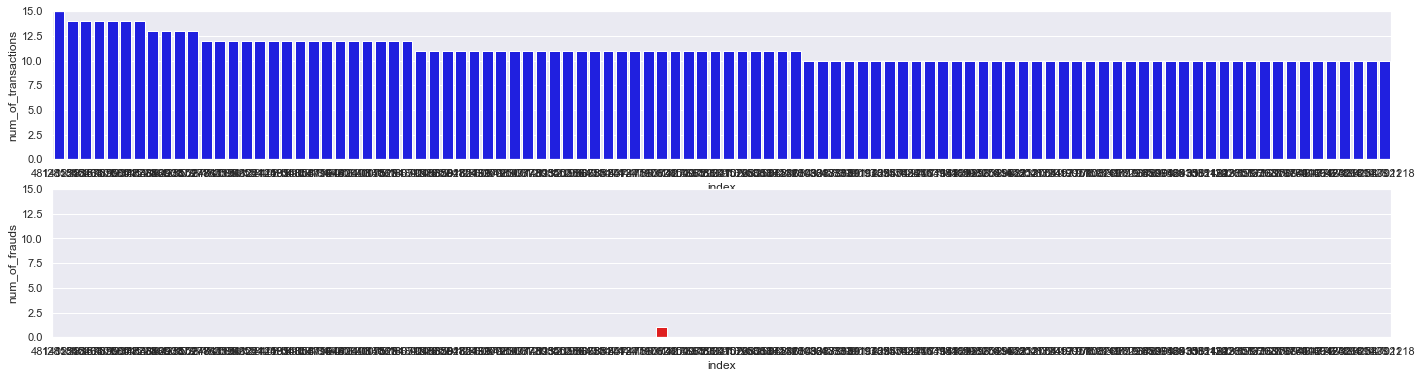

In [45]:
plt.figure(figsize=(24,6))
plt.subplot(2, 1, 1)
sns.barplot(x='index',y='num_of_transactions',data=aux21,color = "blue")
plt.ylim(0,15)
plt.subplot(2, 1, 2)
sns.barplot(x='index',y='num_of_frauds',data=aux21,color = "red")
plt.ylim(0,15)

In [46]:
aux22=aux2[aux2['num_of_frauds']>0]
aux22=aux22.sort_values(by=['num_of_transactions'],ascending=False).head(100).reset_index()

(0.0, 15.0)

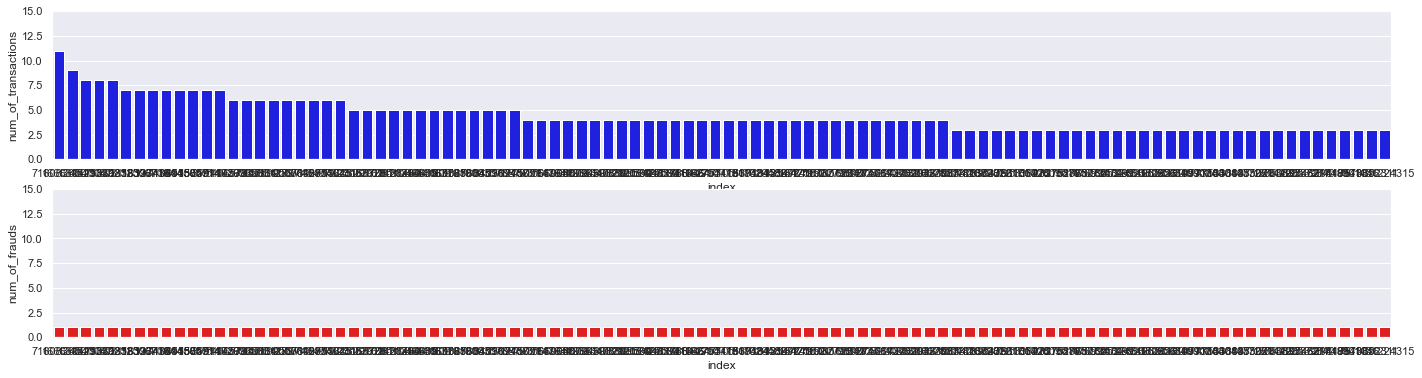

In [47]:
plt.figure(figsize=(24,6))
plt.subplot(2, 1, 1)
sns.barplot(x='index',y='num_of_transactions',data=aux22,color = "blue")
plt.ylim(0,15)
plt.subplot(2, 1, 2)
sns.barplot(x='index',y='num_of_frauds',data=aux22,color = "red")
plt.ylim(0,15)

### Criando colunas de número de transações

In [48]:
count_map = df2['nameDest_num'].value_counts().to_dict()
df2['num_of_transactions_dest']=df2['nameDest_num'].map(count_map)
# df2.sample(2)

In [49]:
count_map = df2['nameOrig_num'].value_counts().to_dict()
df2['num_of_transactions_orig']=df2['nameOrig_num'].map(count_map)
# df2.sample(2)

### Drop redundant columns

In [50]:
# Deletar colunas de numero de conta
df2.drop(['nameOrig_num','nameDest_num'],axis=1,inplace=True)

In [51]:
df2.dtypes

step                          int64
type                         object
amount                      float64
oldbalanceOrg               float64
oldbalanceDest              float64
isFraud                       int64
isFlaggedFraud                int64
FlowOrig                    float64
FlowDest                    float64
amount_anomaly_orig            bool
amount_anomaly_dest            bool
FluxOrig                    float64
FluxDest                    float64
disc_orig_amount            float64
disc_dest_amount            float64
nameDest_char                object
num_of_transactions_dest      int64
num_of_transactions_orig      int64
dtype: object

### Criação de features day e hour

In [52]:
df2['day'] = df2.apply(lambda x: (np.ceil(x['step'] / 24)).astype(int), axis=1)

In [53]:
df2['hour']=df2['day']*24-df2['step']

## Análise univariada

**Análise**
* FluxOrig sem fraude é uma normal ao redor de zero. Com fraude existem valores destoantes

In [54]:
# profile = ProfileReport(df2, title='Profiling Booking' )
# #profile.to_notebook_iframe()
# profile.to_file( output_file='insights_report_after_cleaning.html' )

In [55]:
discrete,continuous,categorical=variable_types(df2)

There are 10 discrete variables
There are 8 continuous variables
There are 2 categorical variables


### Continuous

In [56]:
cont=df2[continuous]

In [57]:
# lets separate between fraud and not fraud
cont_isnotfraud=cont[df2['isFraud']==0]
cont_isfraud=cont[df2['isFraud']==1]

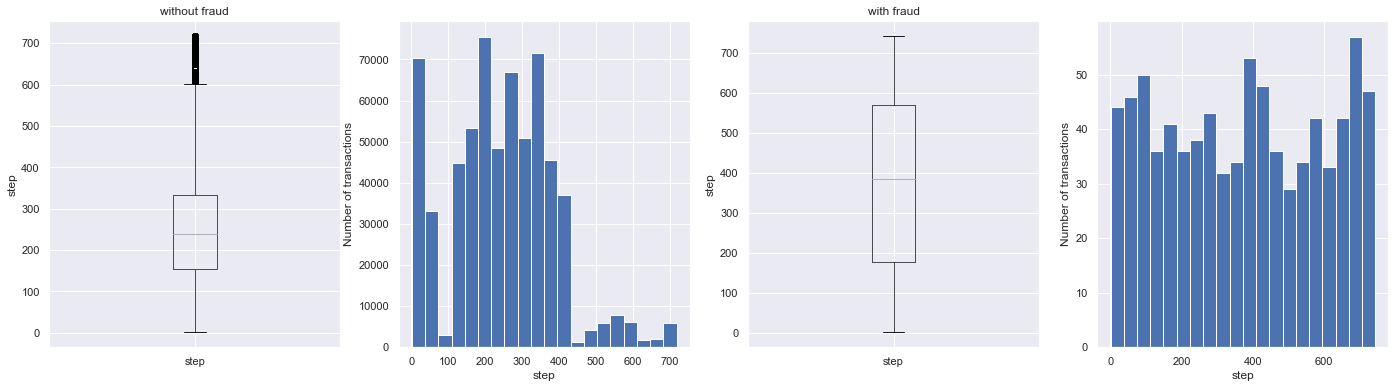

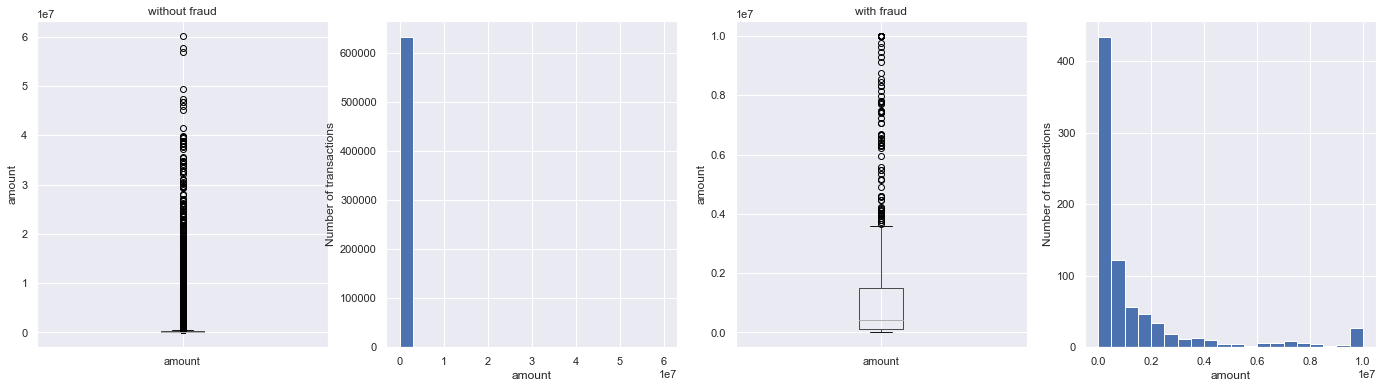

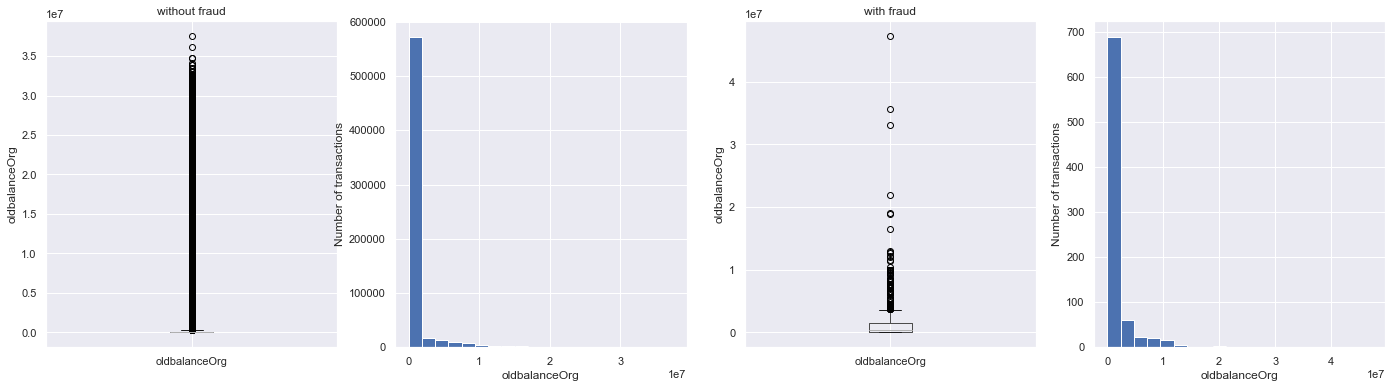

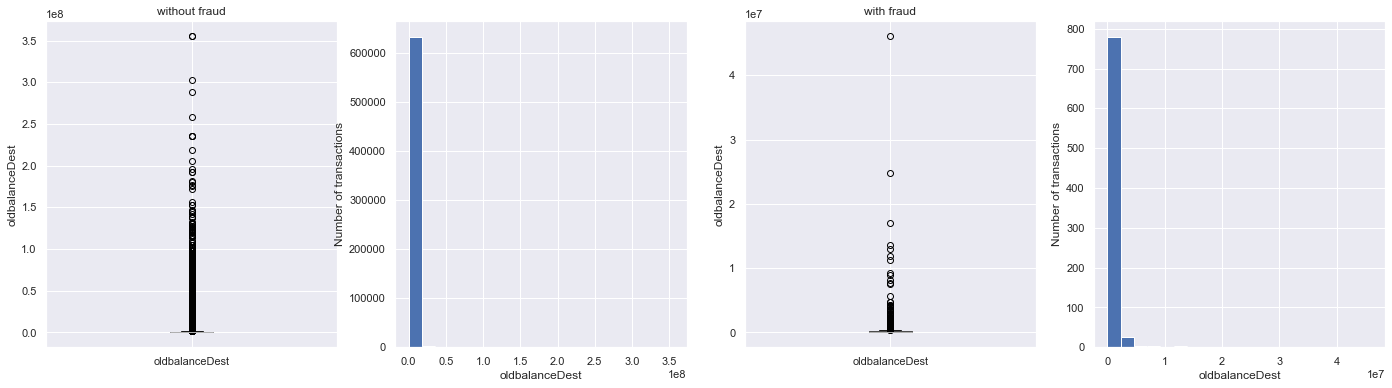

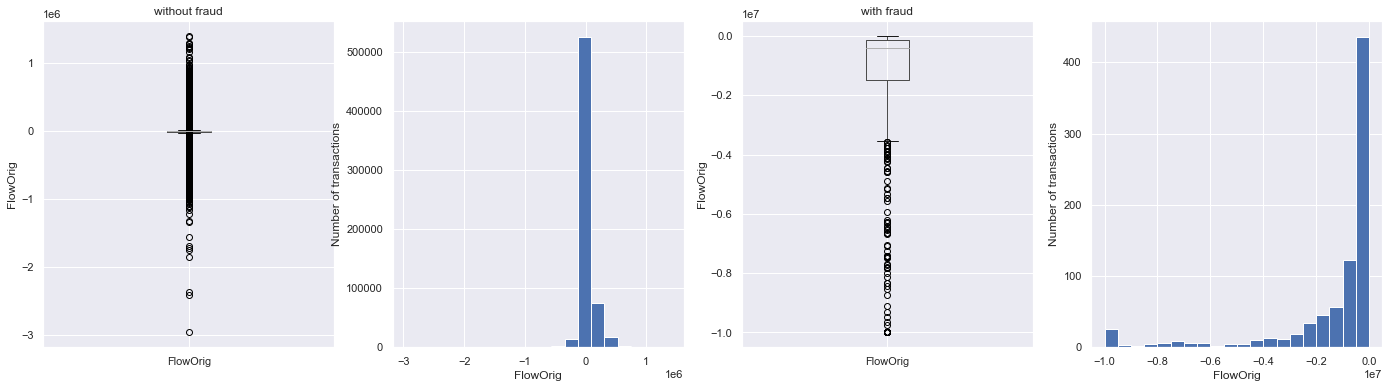

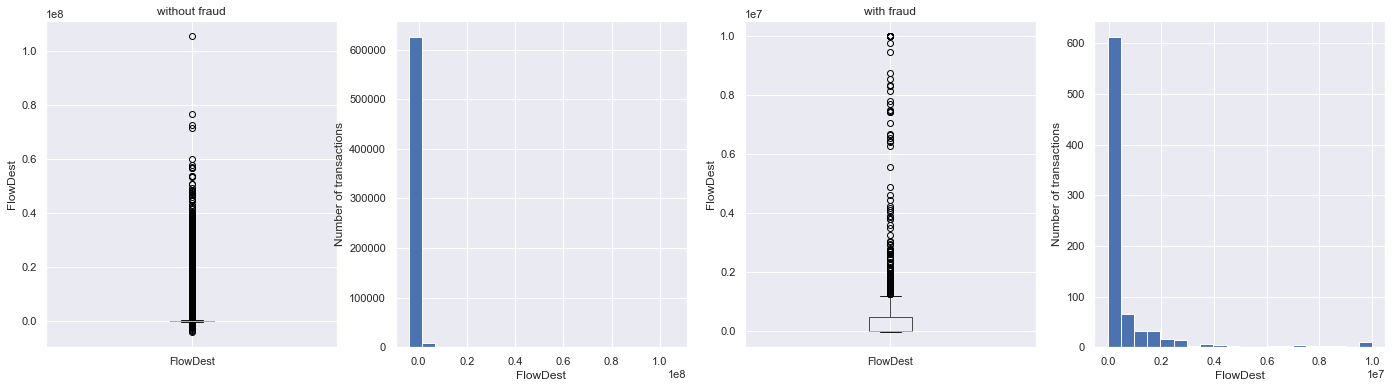

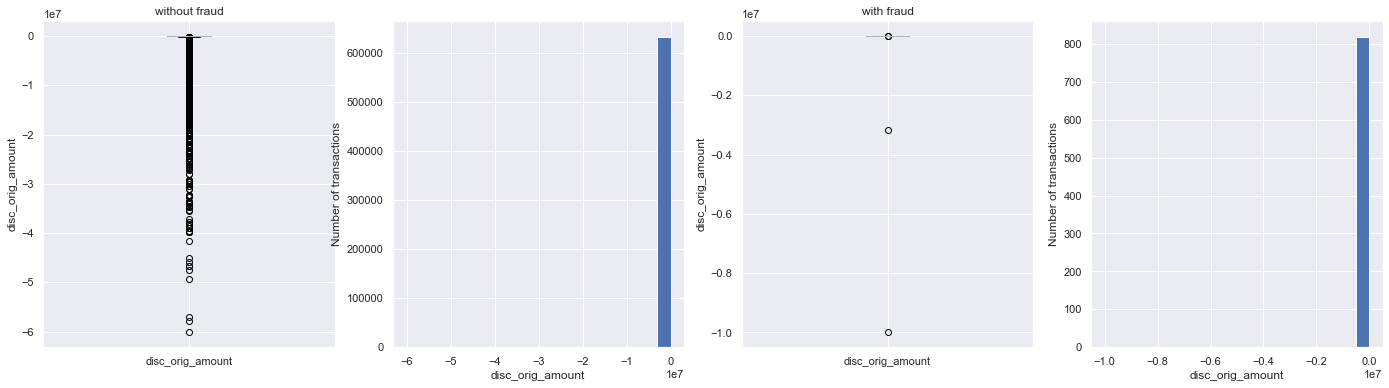

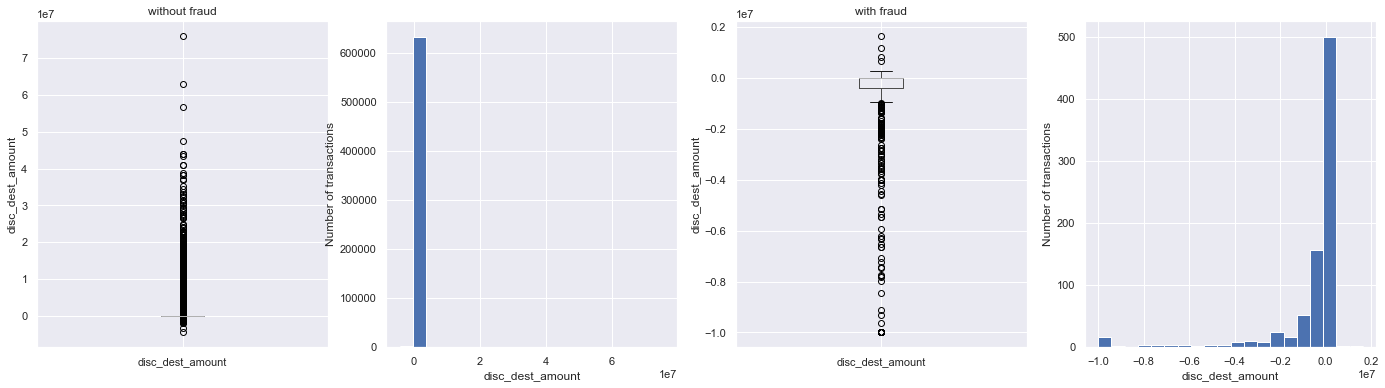

In [58]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    plt.figure(figsize=(24,6))
    plt.subplot(1, 4, 1)
    fig = cont_isnotfraud.boxplot(column=var)
    fig.set_title('without fraud')
    fig.set_ylabel(var)
    
    plt.subplot(1, 4, 2)
    fig = cont_isnotfraud[var].hist(bins=20)
    fig.set_ylabel('Number of transactions')
    fig.set_xlabel(var)
    
    plt.subplot(1, 4, 3)
    fig = cont_isfraud.boxplot(column=var)
    fig.set_title('with fraud')
    fig.set_ylabel(var)
    
    plt.subplot(1, 4, 4)
    fig = cont_isfraud[var].hist(bins=20)
    fig.set_ylabel('Number of transactions')
    fig.set_xlabel(var)

    plt.show()

### Categorical

In [59]:
cat=df2[categorical+discrete].applymap(str)

Text(0, 0.5, 'Number of different categories')

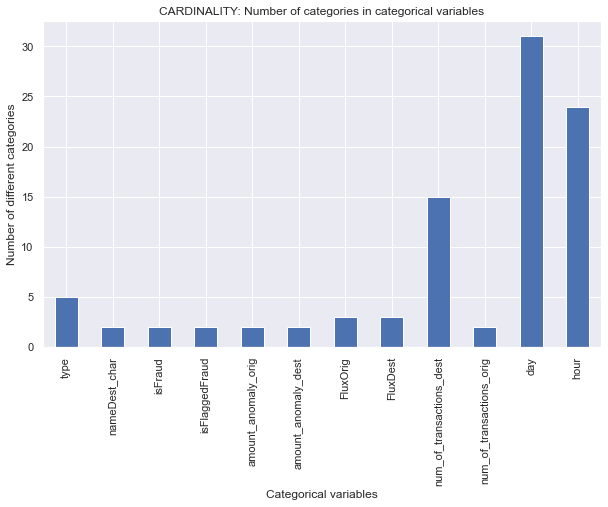

In [60]:
# plot number of categories per categorical variable

cat.nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

In [61]:
target=cat.pop('isFraud')

In [62]:
cat.columns

Index(['type', 'nameDest_char', 'isFlaggedFraud', 'amount_anomaly_orig',
       'amount_anomaly_dest', 'FluxOrig', 'FluxDest',
       'num_of_transactions_dest', 'num_of_transactions_orig', 'day', 'hour'],
      dtype='object')

In [63]:
# lets separate between fraud and not fraud
cat_isnotfraud=cat[df2['isFraud']==0]
cat_isfraud=cat[df2['isFraud']==1]

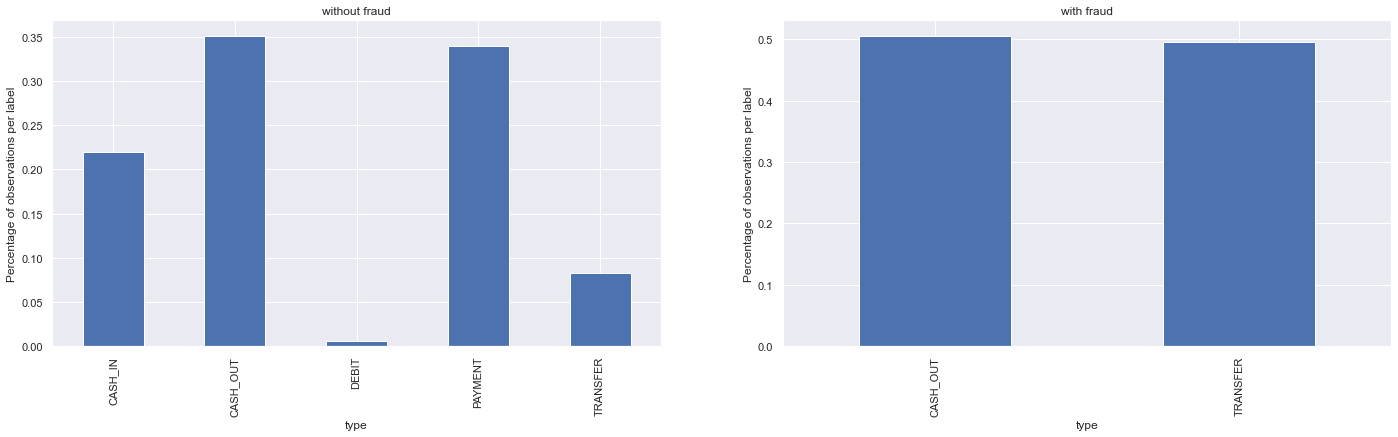

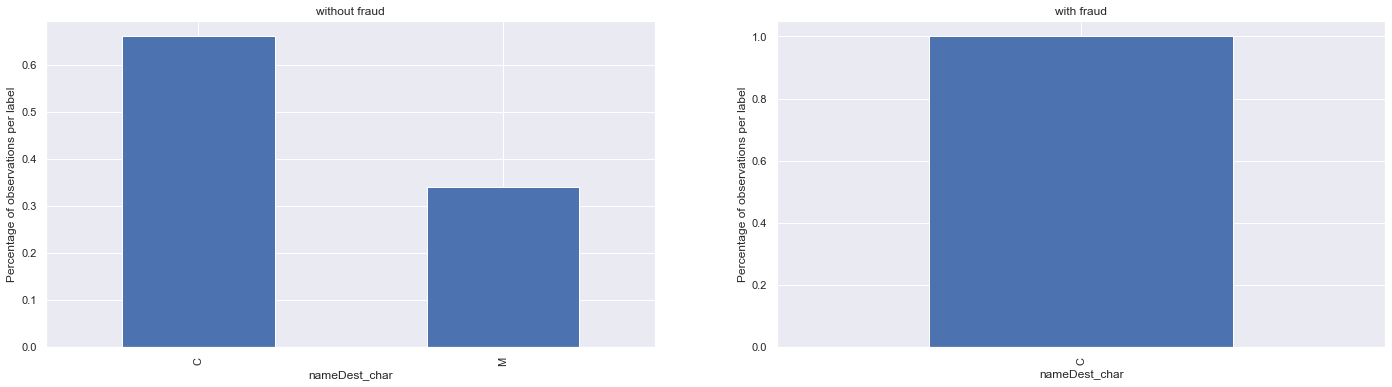

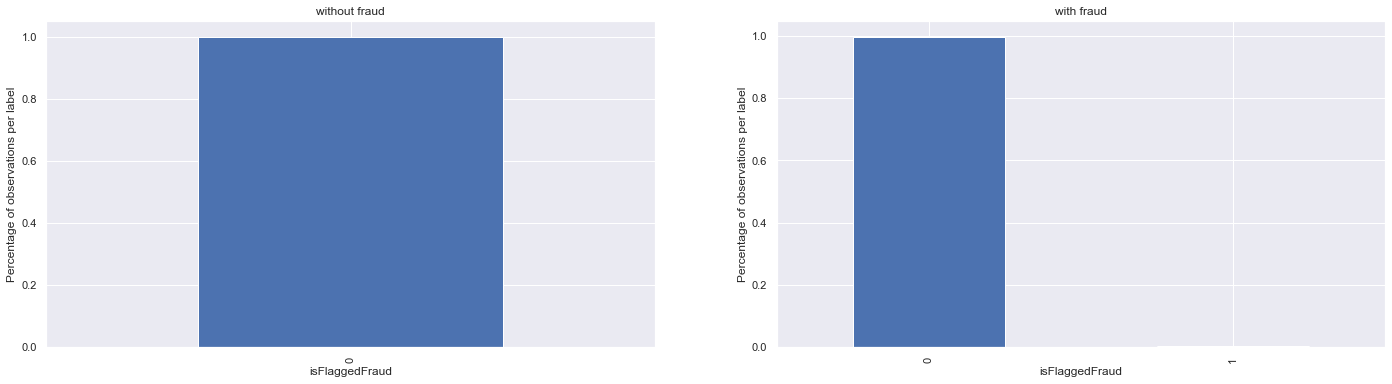

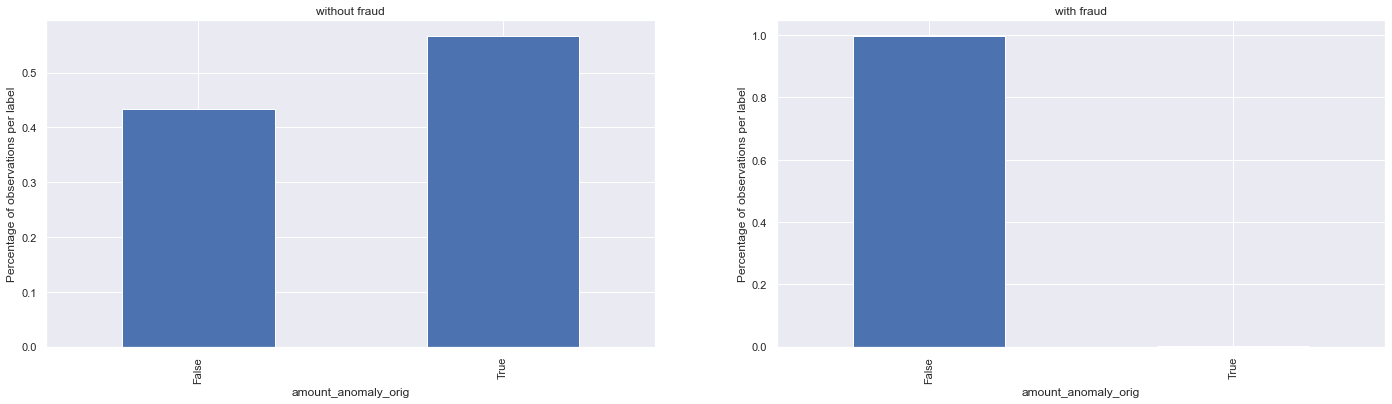

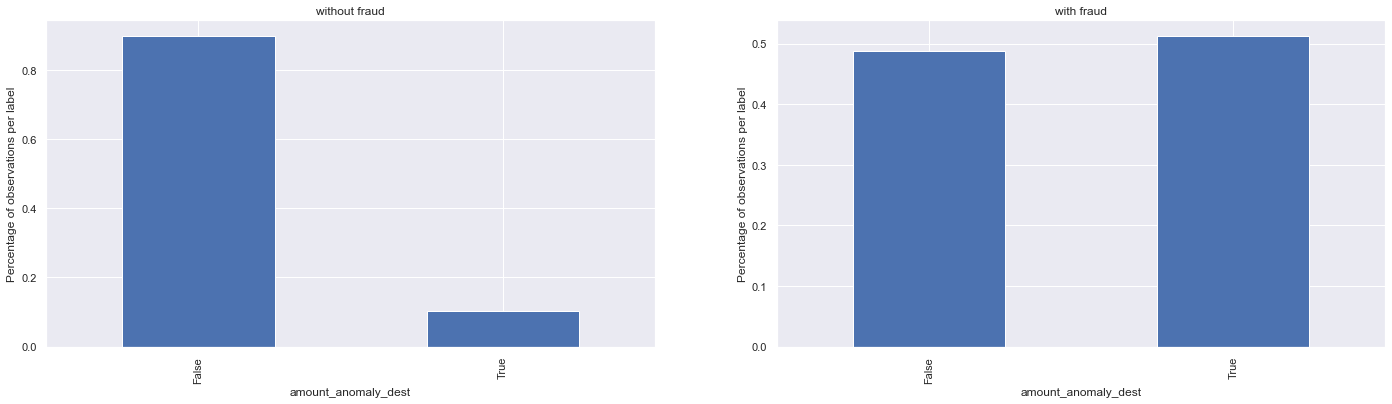

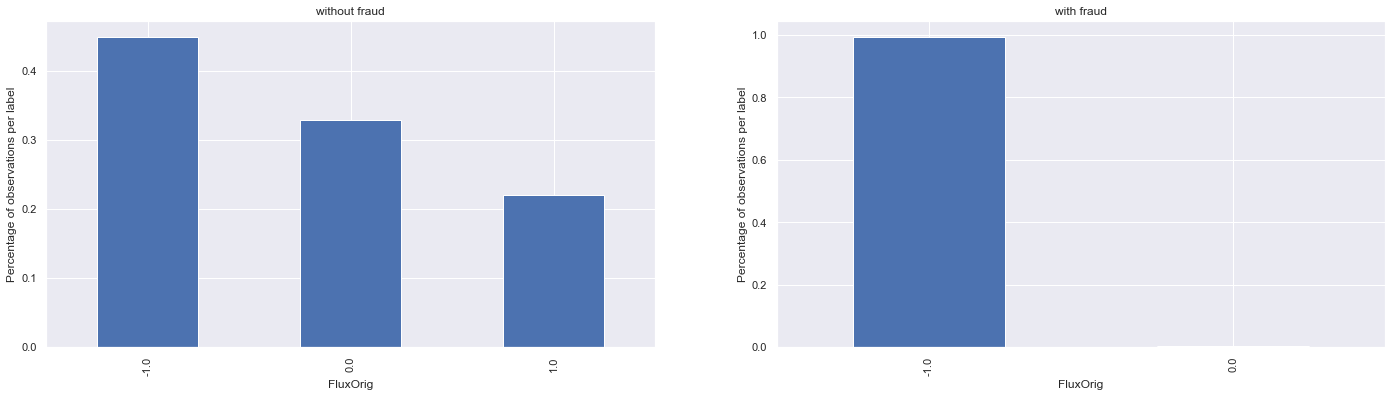

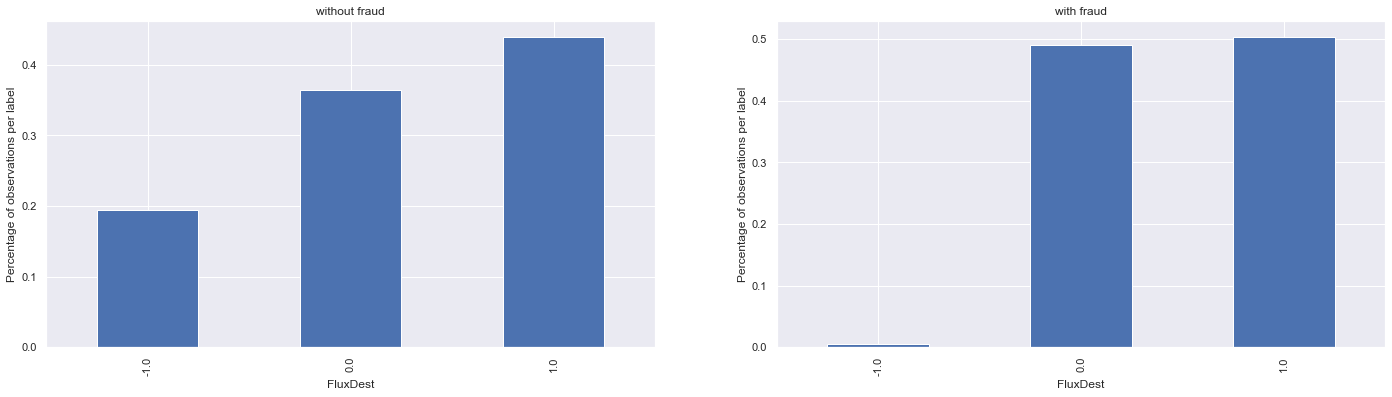

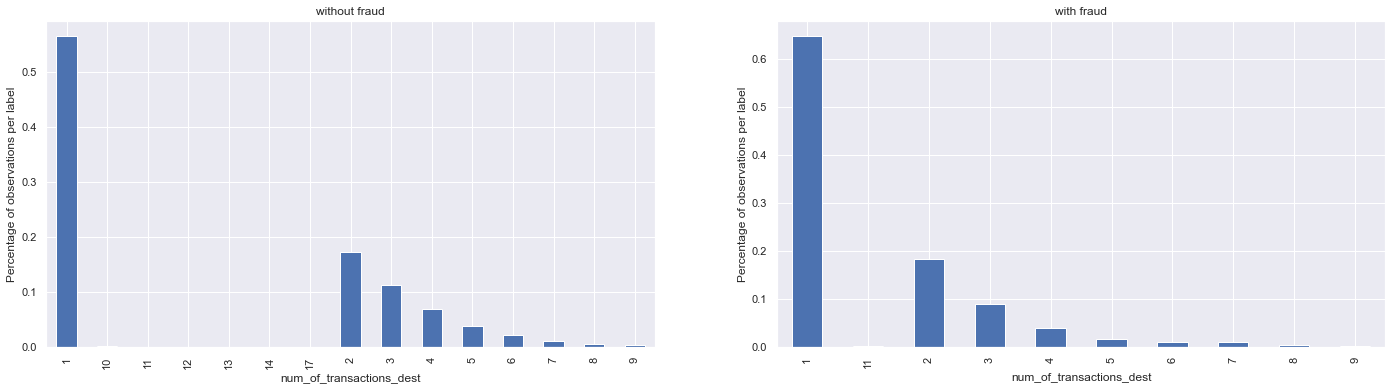

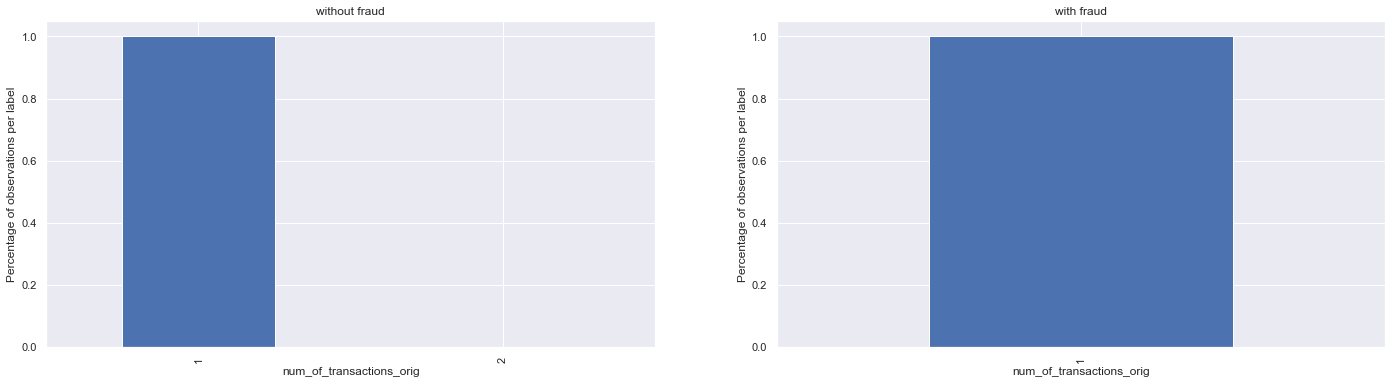

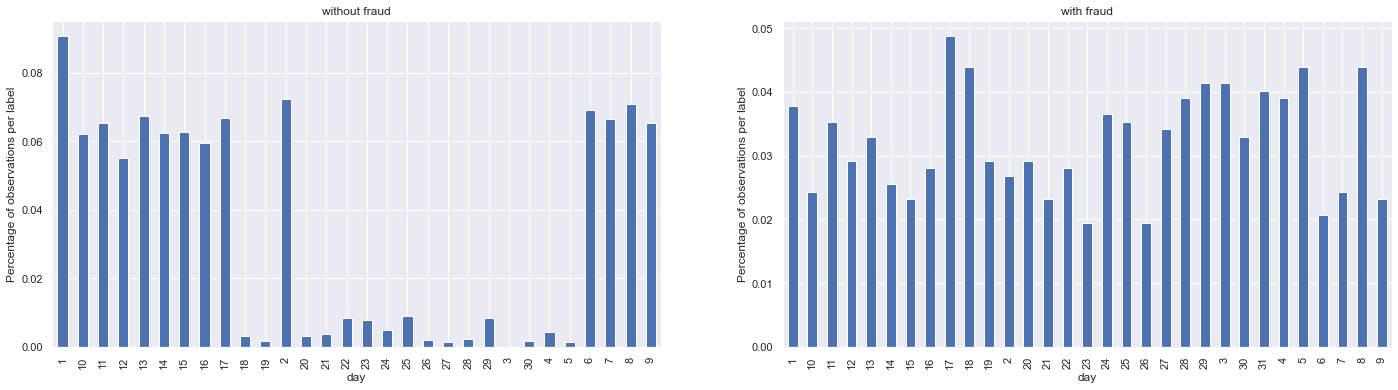

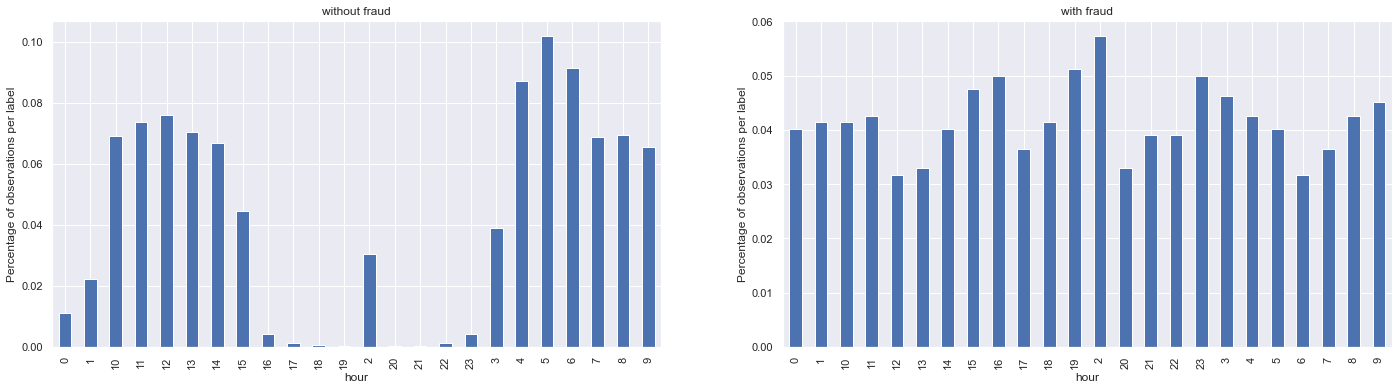

In [64]:
# outliers in discrete and categorical variables
    
for var in cat.columns:
    plt.figure(figsize=(24,6))
    
    plt.subplot(1, 2, 1)
    fig=(cat_isnotfraud.groupby(var)[var].count() / np.float(len(cat_isnotfraud))).plot.bar()
    fig.set_ylabel('Percentage of observations per label')
    fig.set_title('without fraud')
    
    plt.subplot(1, 2, 2)
    fig=(cat_isfraud.groupby(var)[var].count() / np.float(len(cat_isfraud))).plot.bar()
    fig.set_ylabel('Percentage of observations per label')
    fig.set_title('with fraud')
    
    plt.show()

**Análise**
* Só tem fraude em cash_out e transferencia
* Só fraudam com pessoa física
* Para o destino anomalia no fluxo de caixa costuma dizer que é fraude, para a origem é o contrário
* Todas as fraudes tem como origem compra (outflow)
* Maior parte das fraudes tem como destino venda (inflow)
* Toda os clientes que fizeram mais de uma transação não são fraudadores

## Análise multivariada

### continuous + discrete

**Análise**

Altas correlacoes:
* amount x FlowDest
* amount x disc_orig_amount
* step x day

<AxesSubplot:>

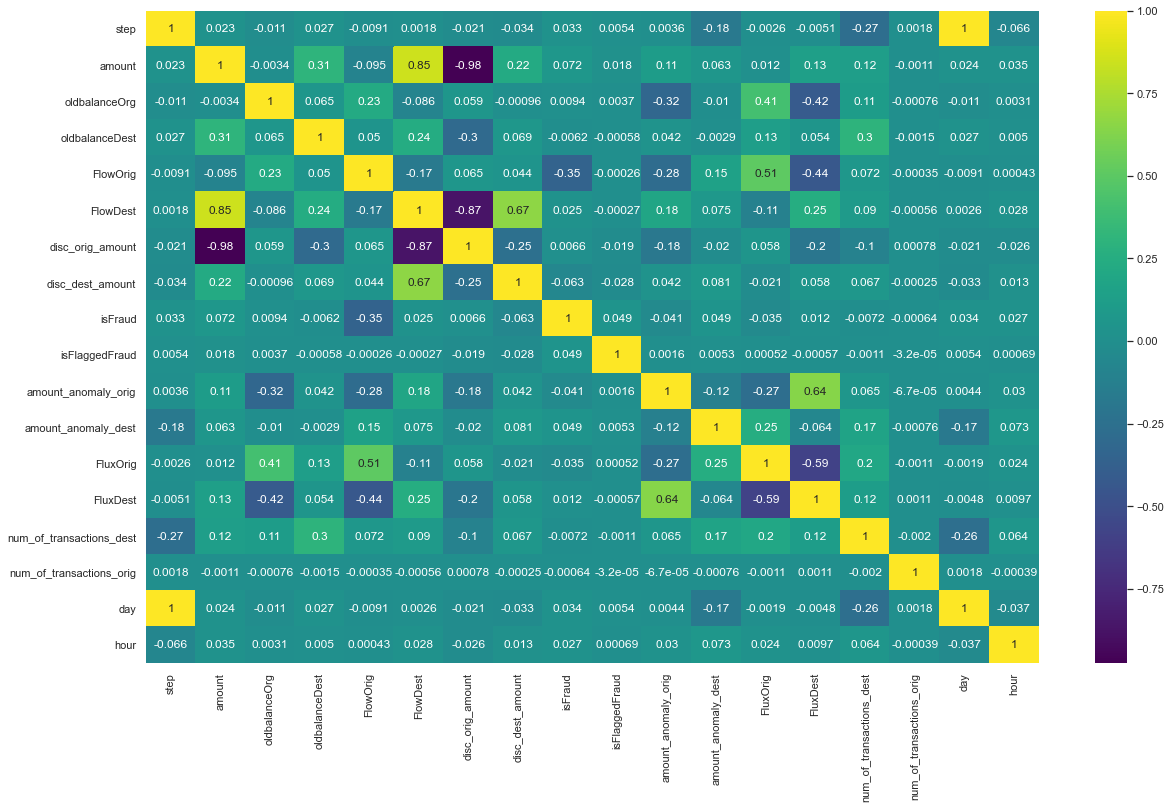

In [65]:
plt.figure(figsize=(20,12))
sns.heatmap(df2[continuous+discrete].corr(method='pearson'),cmap='viridis',annot=True)

### Categorical

**Análise**

Altas correlacoes:

* type x namDest_char: O tipo de pagamento define completamente o nameDest_char porque todo Merchant só aceita Payment como pagamento
* type x FluxDest
* Dest_char x FluxDest

In [66]:
cat=df2[categorical+discrete].applymap(str)

In [67]:
cat_attributes_list = cat.columns

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v( df2[ ref ], df2[ feat ] )
        
        # append a list
        corr_list.append( corr )
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

<AxesSubplot:>

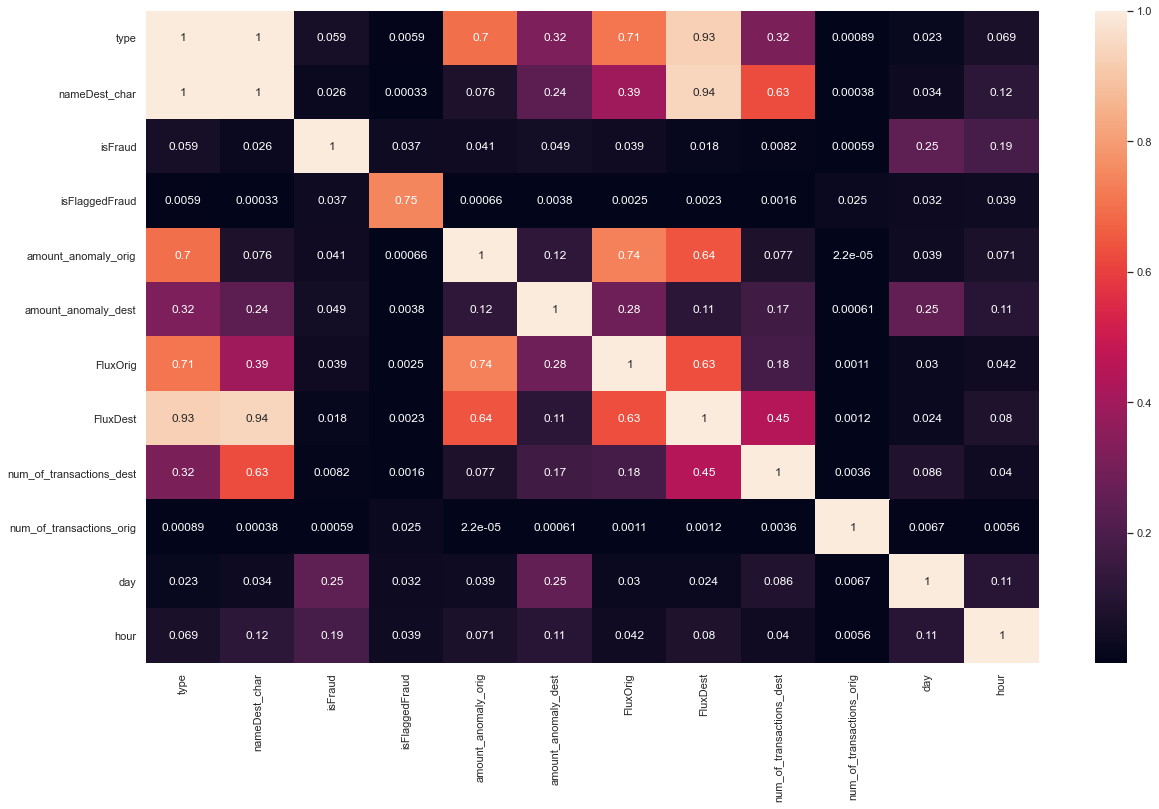

In [68]:
plt.figure(figsize=(20,12))
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True )

## Análise bivariada

### H1
**H1.** step de fraudes são uniformes e transações verdadeiras não são. **Verdade!**

**Análise**
* oldbalancedest quase sempre proximo de 0 quando é fraude
* floworig bastante outliers e valores proximos de 0 quando é fraude
* flowdest bastante outliers e valores proximos de 0 quando é fraude
* disc_x_amount mais chances de ser fraude quando próximos de 0
* Existem horas do dia com mais transacoes para operacoes nao fraudulentas enquanto que para fraudulenta é meio caótico

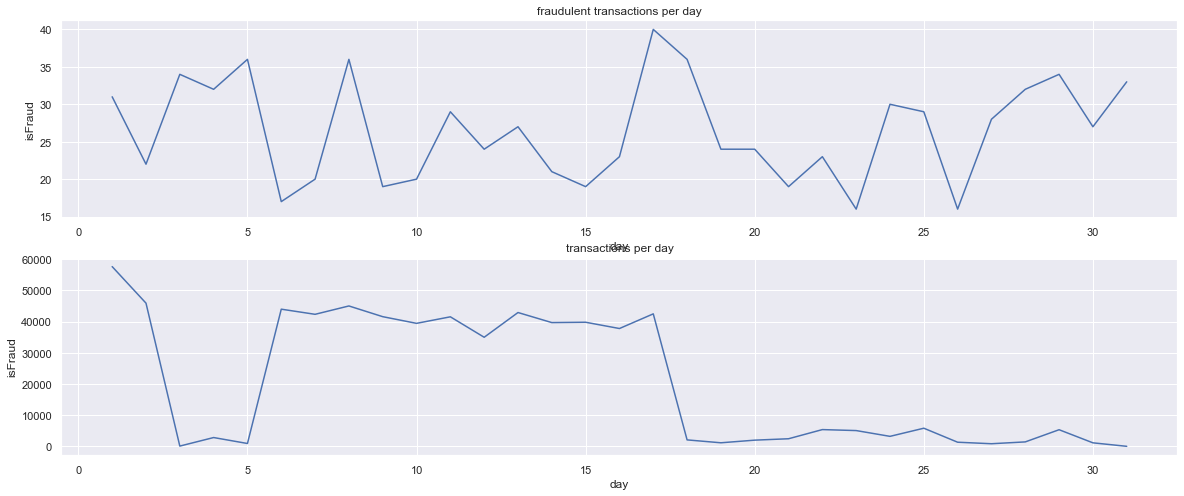

In [69]:
 # plot fraudulent transactions per day
aux1 = df2[['day', 'isFraud']].groupby('day').sum().reset_index()
aux2 = df2[['day', 'isFraud']].groupby('day').count().reset_index()
# set up figure size
plt.subplots(figsize=(20,8))
plt.subplot(2, 1, 1)
sns.lineplot(x='day', y='isFraud', data=aux1).set_title('fraudulent transactions per day');
plt.subplot(2, 1, 2)
sns.lineplot(x='day', y='isFraud', data=aux2).set_title('transactions per day');

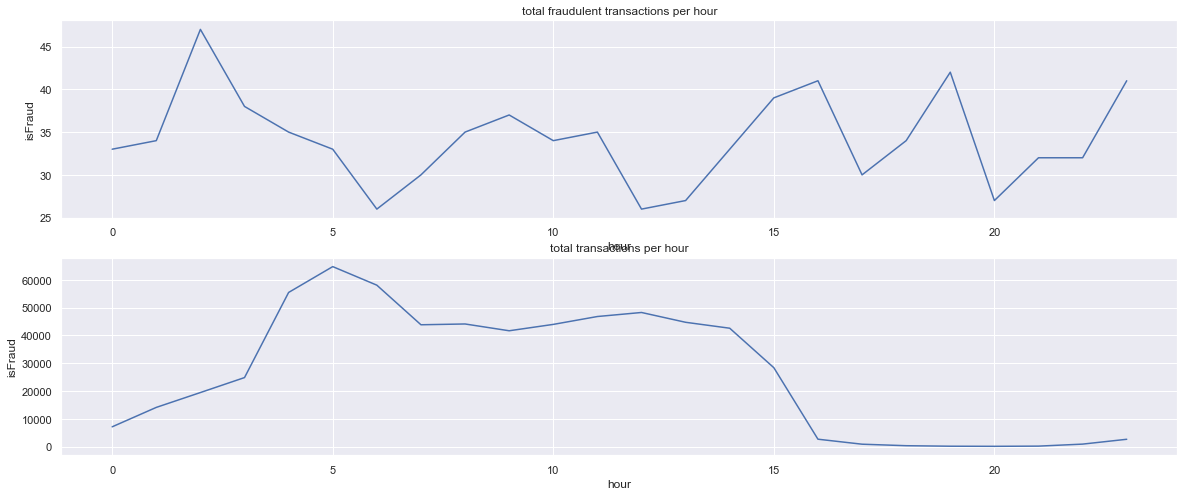

In [70]:
 # plot fraudulent transactions per day
aux1 = df2[['hour', 'isFraud']].groupby('hour').sum().reset_index()
aux2 = df2[['hour', 'isFraud']].groupby('hour').count().reset_index()
# set up figure size
plt.subplots(figsize=(20,8))
plt.subplot(2, 1, 1)
sns.lineplot(x='hour', y='isFraud', data=aux1).set_title('total fraudulent transactions per hour');
plt.subplot(2, 1, 2)
sns.lineplot(x='hour', y='isFraud', data=aux2).set_title('total transactions per hour');

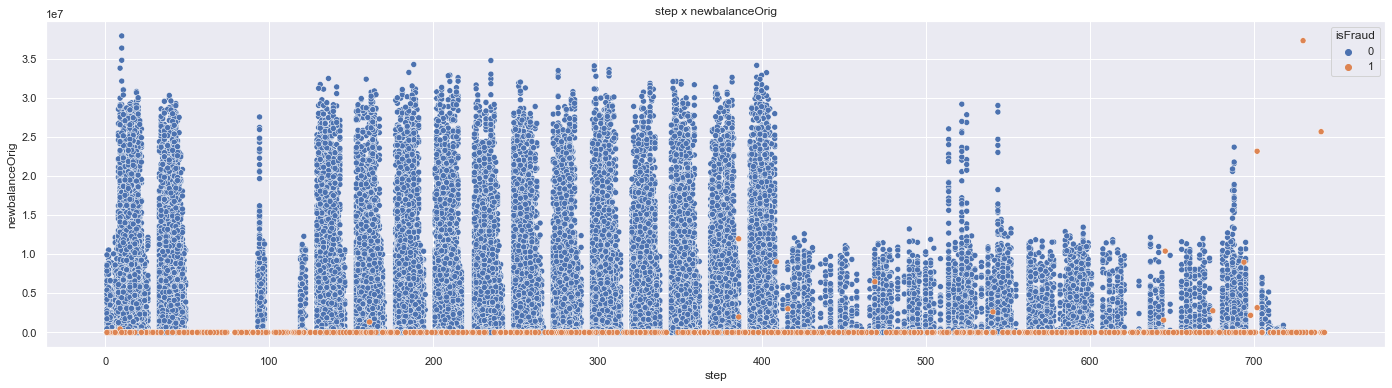

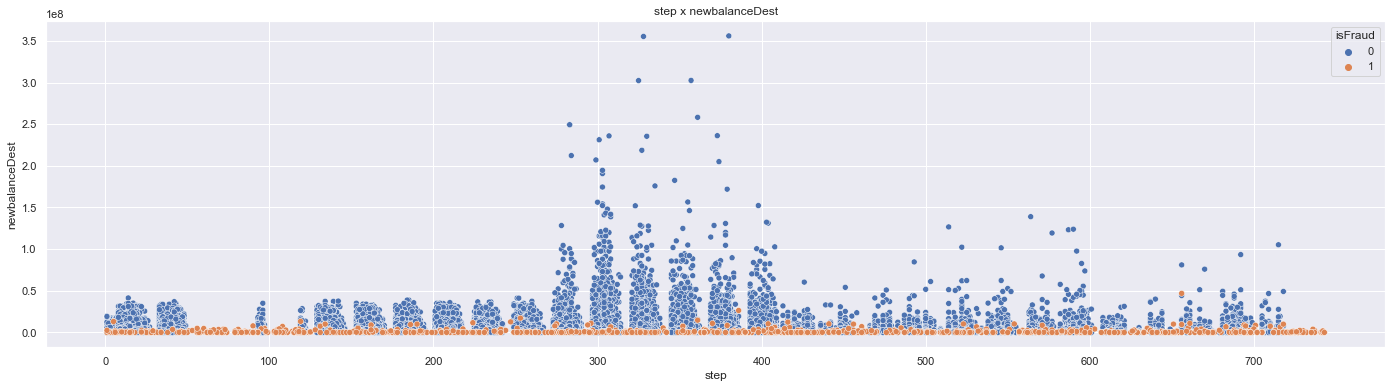

In [162]:
for var in ['newbalanceOrig','newbalanceDest']:
    plt.figure(figsize=(24,6))
    sns.scatterplot(x='step', y=var, hue='isFraud', data=df1)
    plt.ylabel(var)
    plt.title('step x ' + var)
    plt.show()

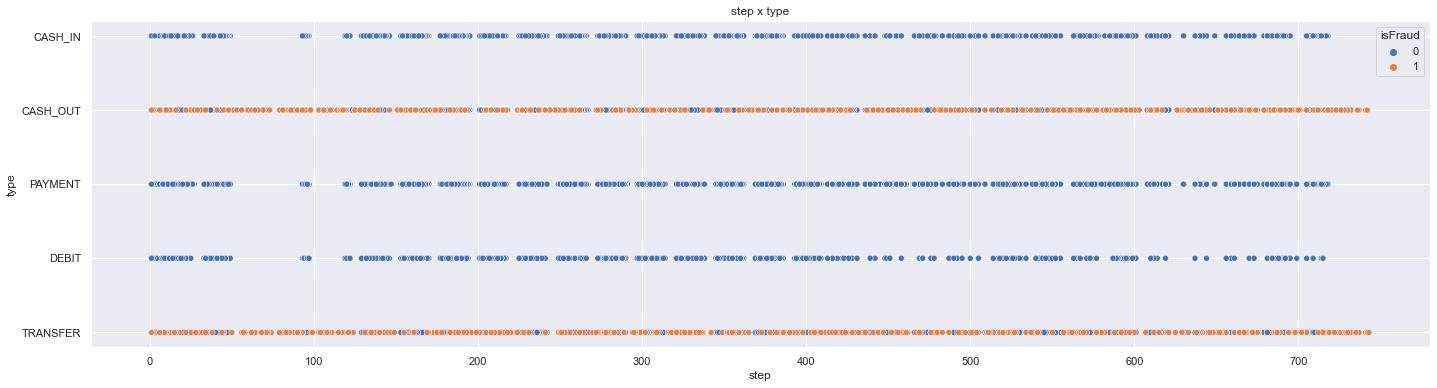

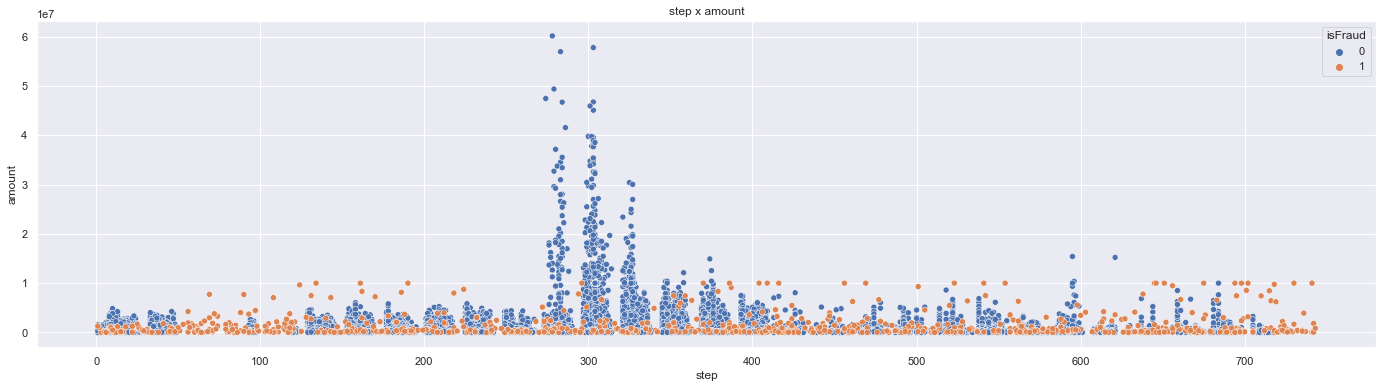

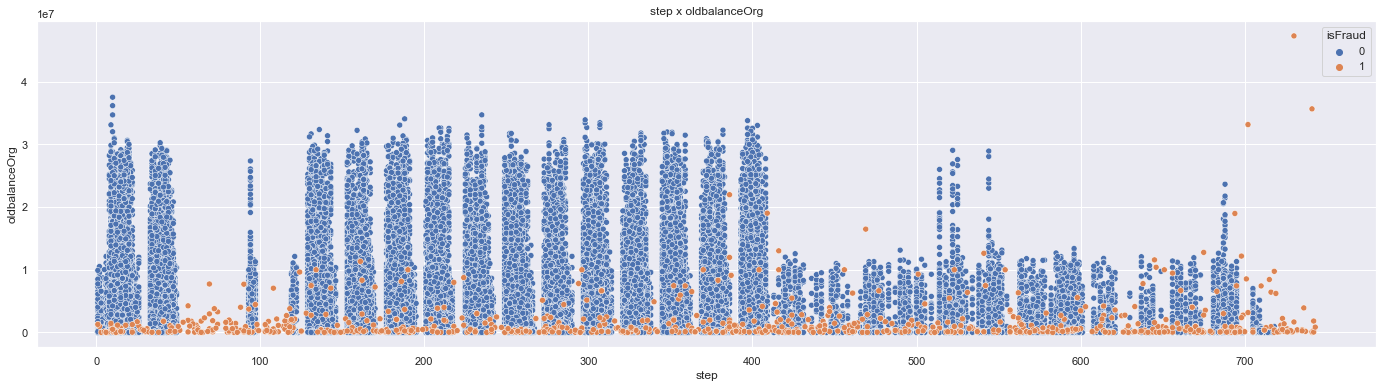

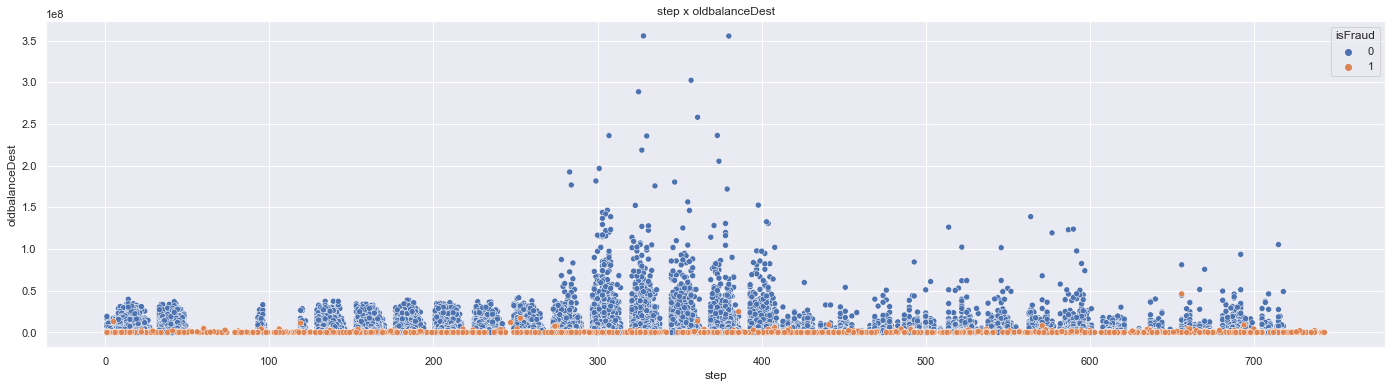

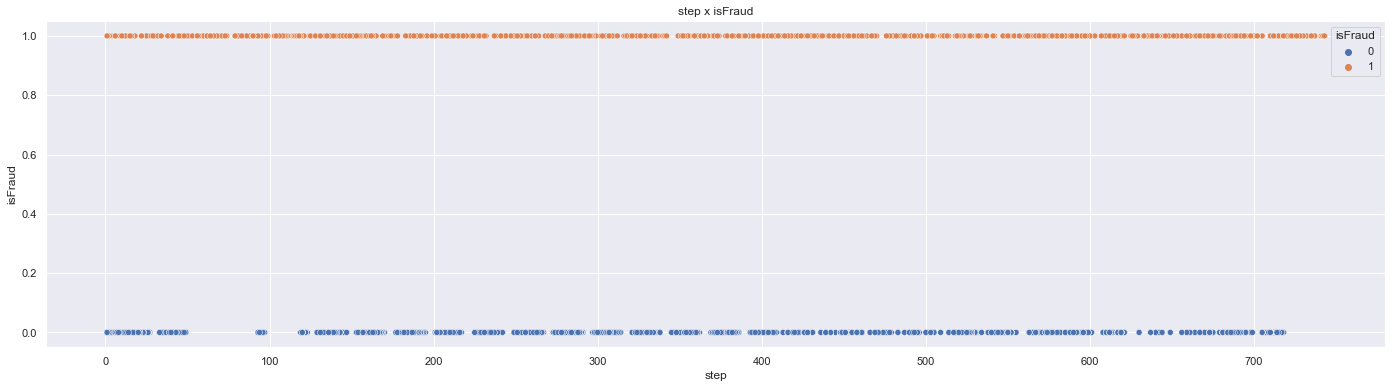

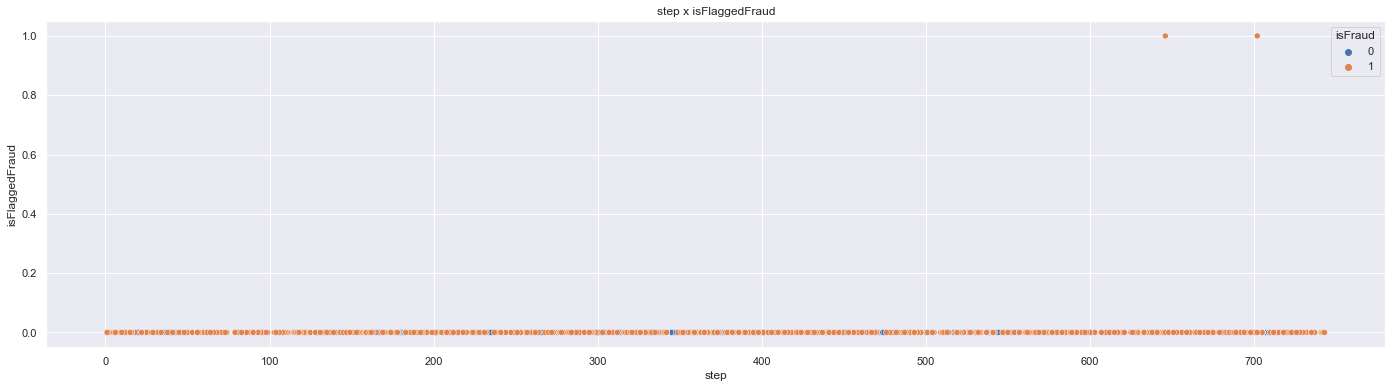

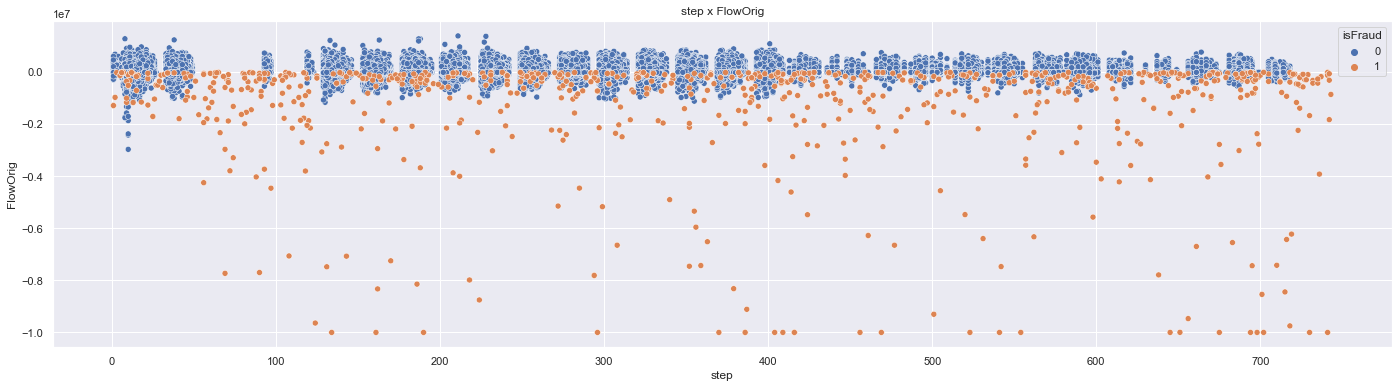

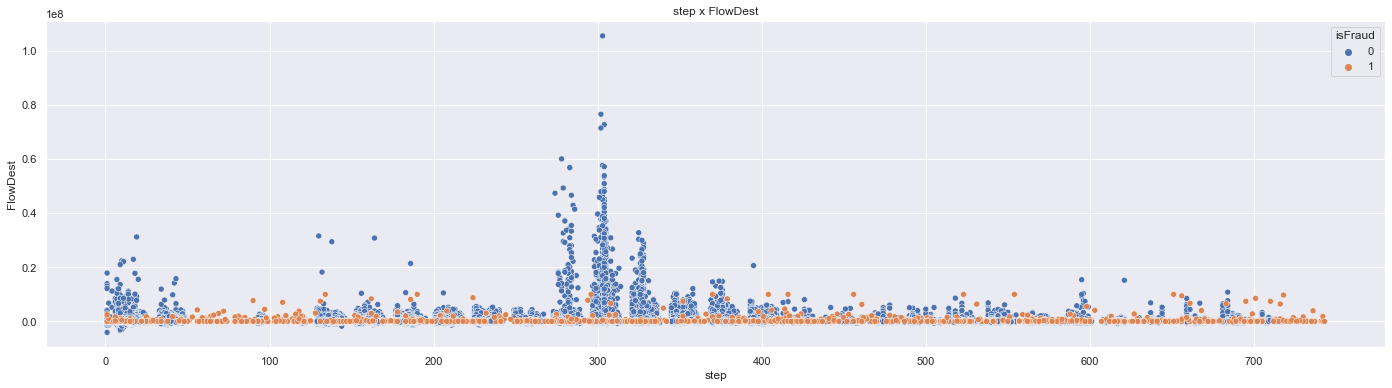

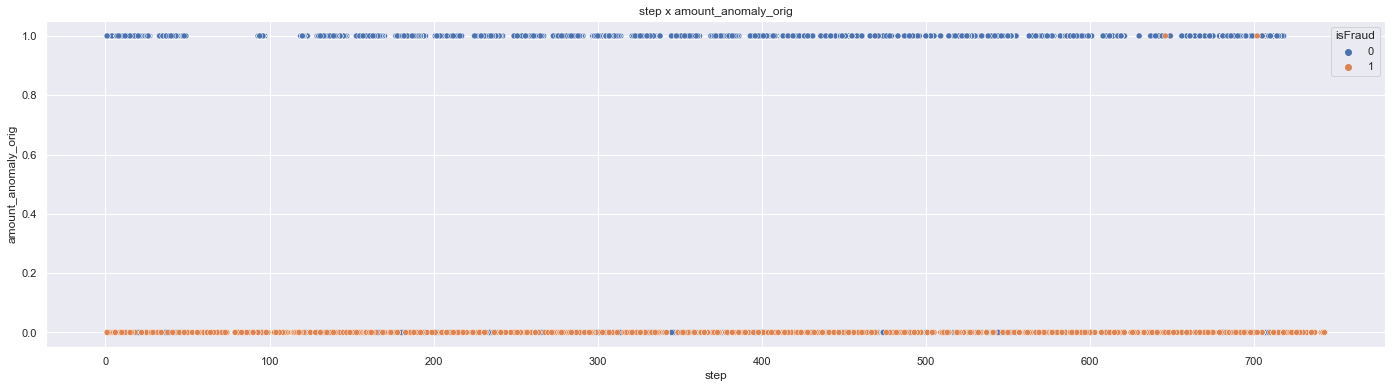

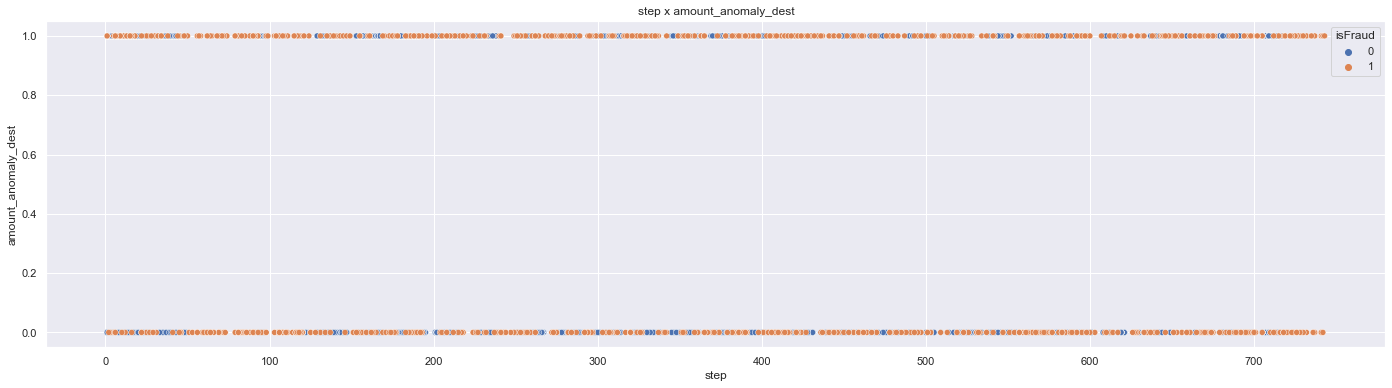

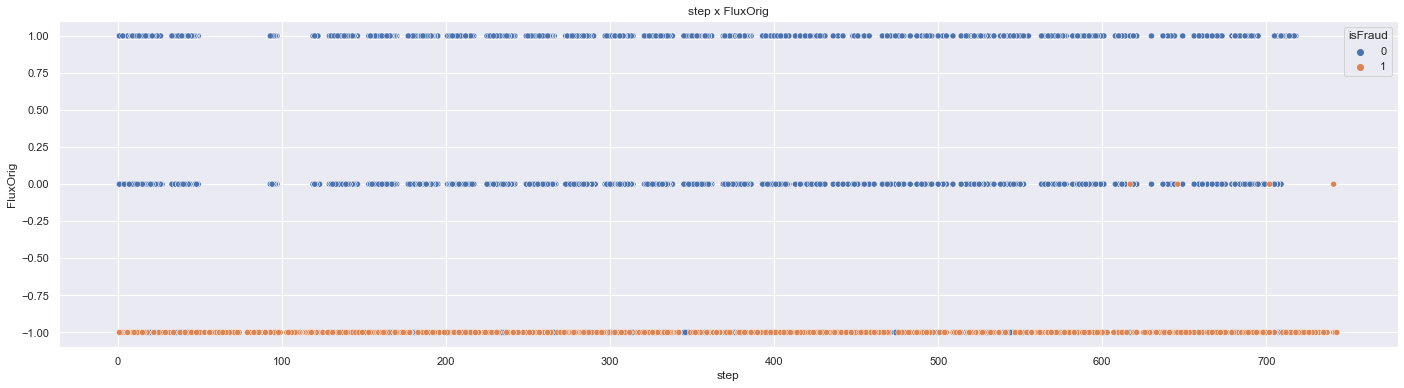

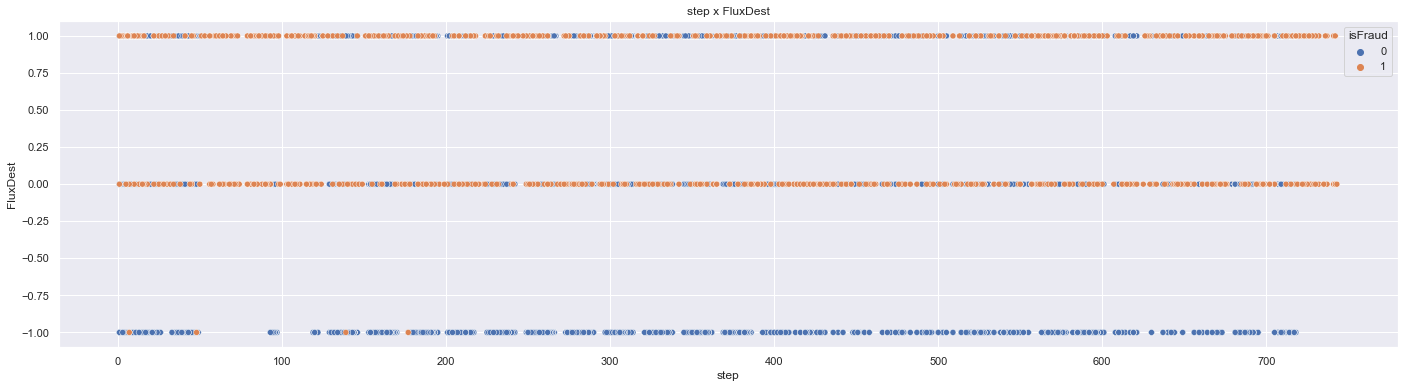

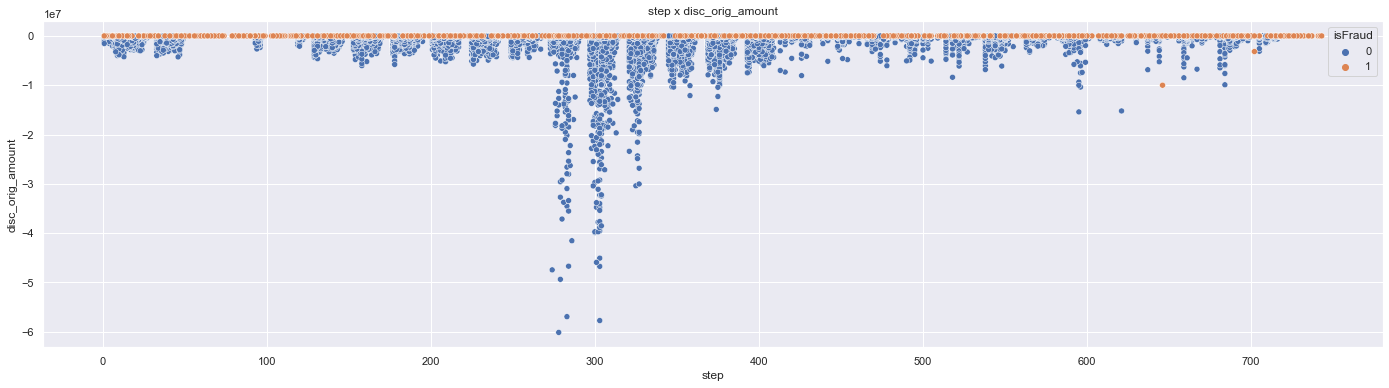

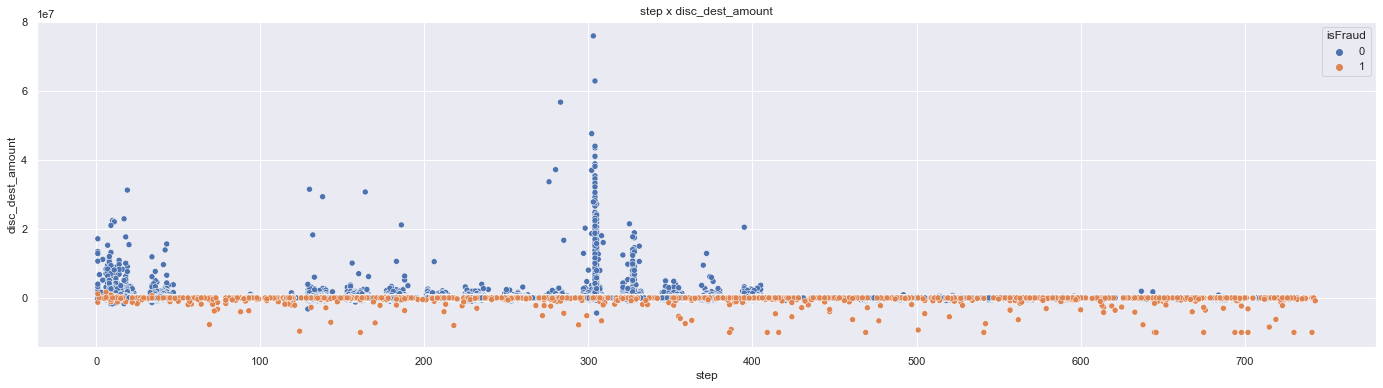

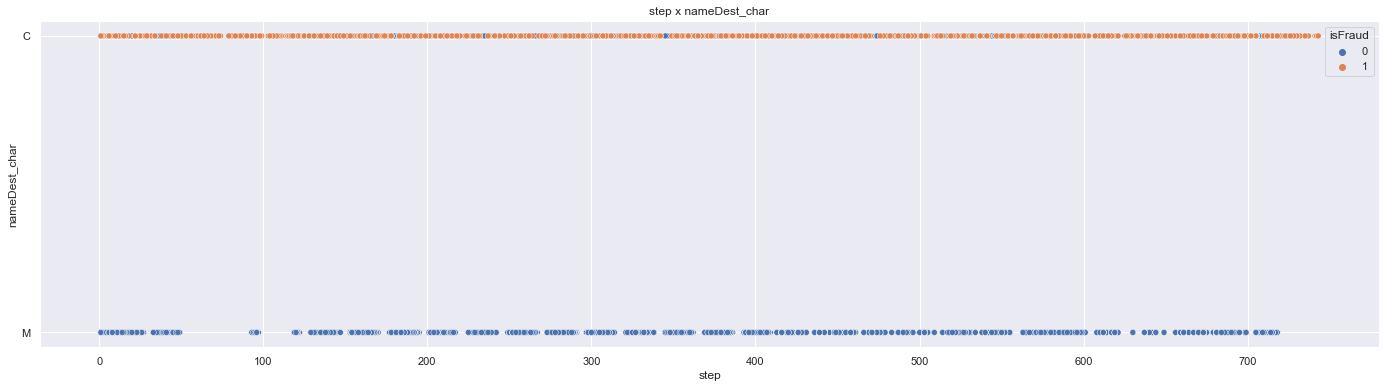

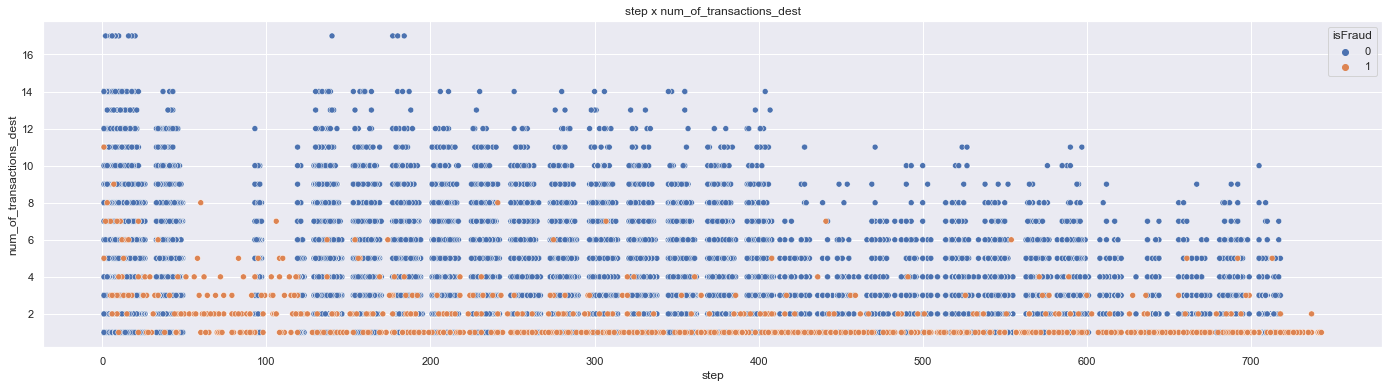

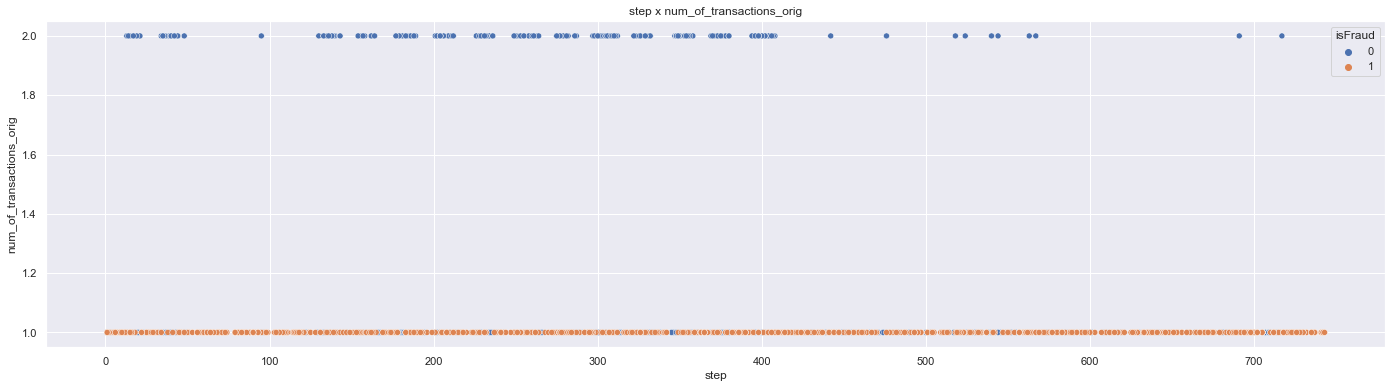

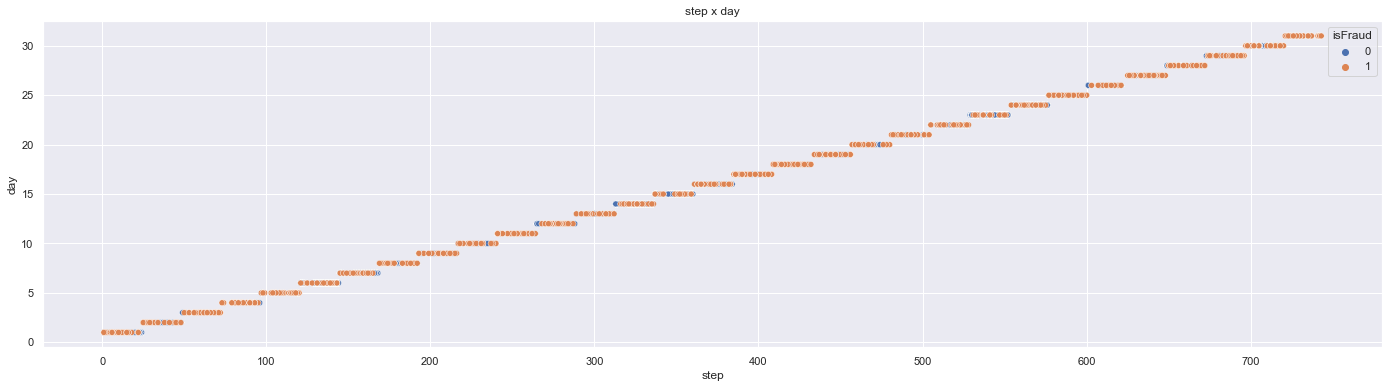

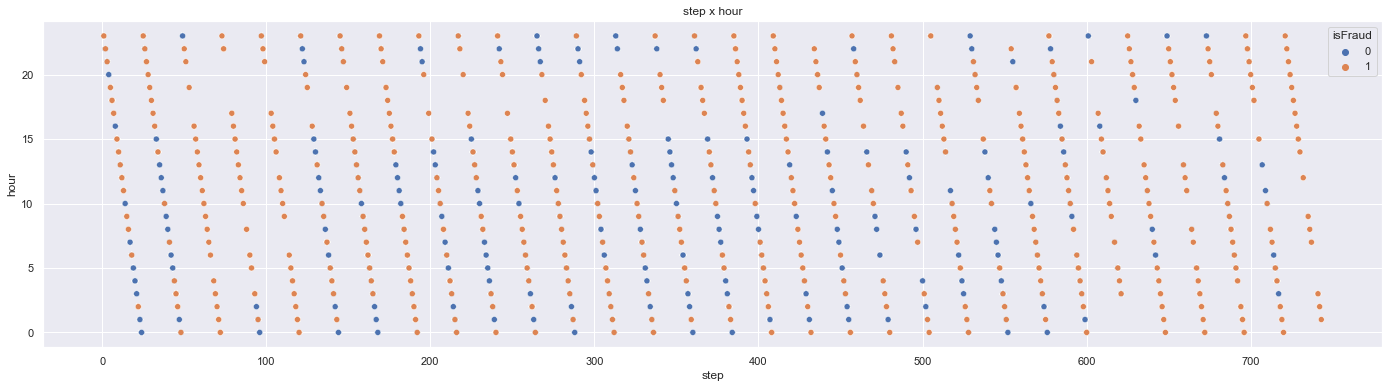

In [71]:
a=list(df2.columns)
a.remove('step')
for var in a:
    plt.figure(figsize=(24,6))
    sns.scatterplot(x='step', y=var, hue='isFraud', data=df2)
    plt.ylabel(var)
    plt.title('step x ' + var)
    plt.show()

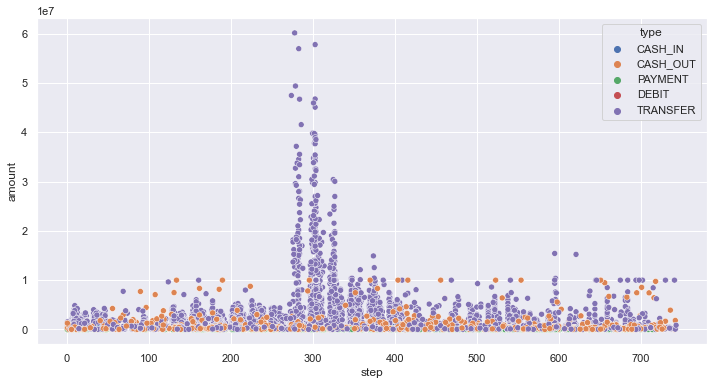

In [72]:
 # type feature scatter plot
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='amount', hue='type', data=df2);

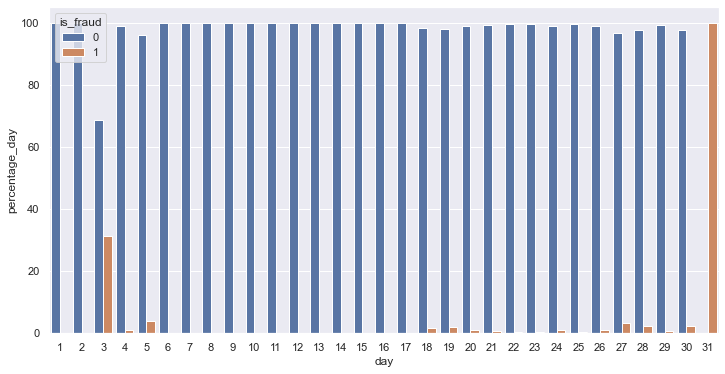

In [73]:
 # percentage of transactions per day
auxh13 = df2[['day', 'amount', 'isFraud']].groupby(['day', 'isFraud']).count().reset_index()
auxh13.columns = ['day', 'is_fraud', 'transactions']
auxh14 = auxh13[['day', 'transactions']].groupby('day').sum().reset_index()
auxh14.columns = ['day', 'transactions_day']
auxh15 = pd.merge(auxh13, auxh14, how='left', on='day')
auxh15['percentage_day'] = np.round(((auxh15['transactions'] / auxh15['transactions_day']) * 100), decimals=2)

# plot percentage per day
plt.subplots(figsize=(12,6))
sns.barplot(x='day', y='percentage_day', hue='is_fraud', data=auxh15);

### H2
**H2.** Transações do tipo transfer e cash-out tem mais risco de fraude **Verdade!**

Provado na análise univariada

### H3
**H3.** Transacoes maiores tem mais risco de fraude **Verdade!**

80% das operações fraudulentas são até 250,000 contra 40% de fraudulentas

In [75]:
aux_fraud=df2[df2['isFraud']==1]
aux_fraud.describe().amount

count    8.210000e+02
mean     1.414504e+06
std      2.337539e+06
min      0.000000e+00
25%      1.216268e+05
50%      4.171291e+05
75%      1.506795e+06
max      1.000000e+07
Name: amount, dtype: float64

In [76]:
aux_notfraud=df2[df2['isFraud']==0]
aux_notfraud.describe().amount

count    6.354410e+05
mean     1.790815e+05
std      6.081749e+05
min      4.000000e-02
25%      1.330733e+04
50%      7.418321e+04
75%      2.077343e+05
max      6.015446e+07
Name: amount, dtype: float64

In [77]:
# transferência de fraudes possuem média, mediana e std maiores. No entanto, o máximo é menor
(aux_fraud.describe().amount)/(aux_notfraud.describe().amount)

count    0.001292
mean     7.898658
std      3.843531
min      0.000000
25%      9.139836
50%      5.622958
75%      7.253474
max      0.166239
Name: amount, dtype: float64

In [78]:
bins1 = list(np.arange(0, 1e7, 2.5e5))
amount_binned = pd.cut(aux_fraud['amount'], bins=bins1)

In [79]:
(amount_binned.value_counts(normalize=True)*100).head(5)

(0.0, 250000.0]           39.798489
(250000.0, 500000.0]      14.609572
(500000.0, 750000.0]       8.816121
(750000.0, 1000000.0]      6.549118
(1000000.0, 1250000.0]     4.408060
Name: amount, dtype: float64

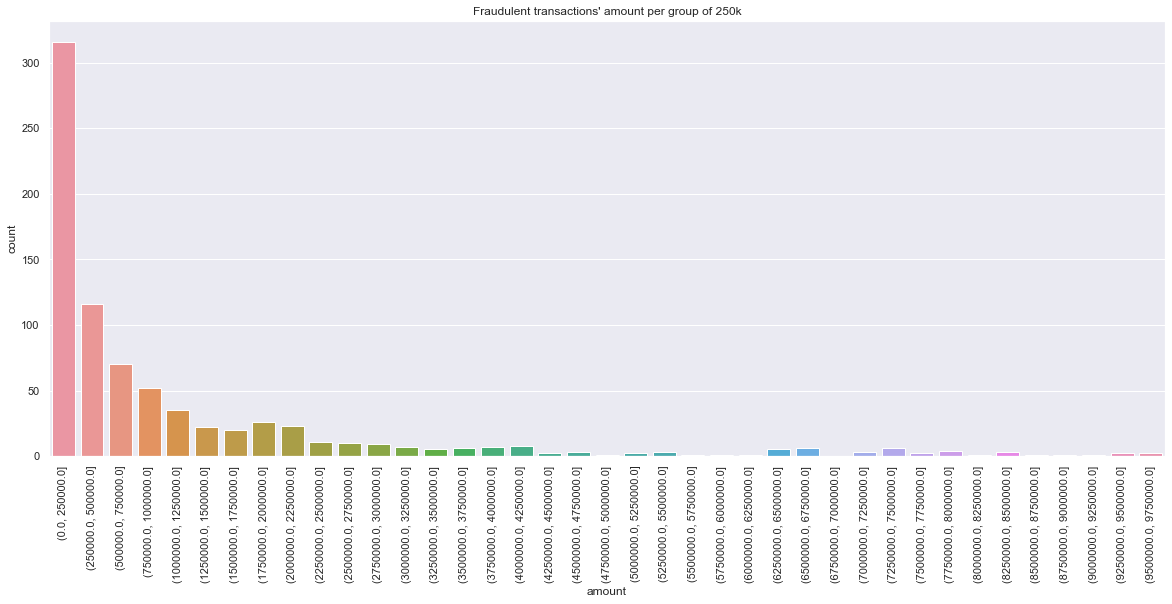

In [80]:
plt.figure(figsize=(20,8))
sns.countplot( x=amount_binned).set_title("Fraudulent transactions' amount per group of 250k")
# rotate x axis
plt.xticks(rotation=90);

In [81]:
bins1 = list(np.arange(0, 1e7, 2.5e5))
amount_binned = pd.cut(aux_notfraud['amount'], bins=bins1)

In [82]:
(amount_binned.value_counts(normalize=True)*100).head(5)

(0.0, 250000.0]           80.590757
(250000.0, 500000.0]      14.191608
(500000.0, 750000.0]       2.419796
(750000.0, 1000000.0]      0.873911
(1000000.0, 1250000.0]     0.543123
Name: amount, dtype: float64

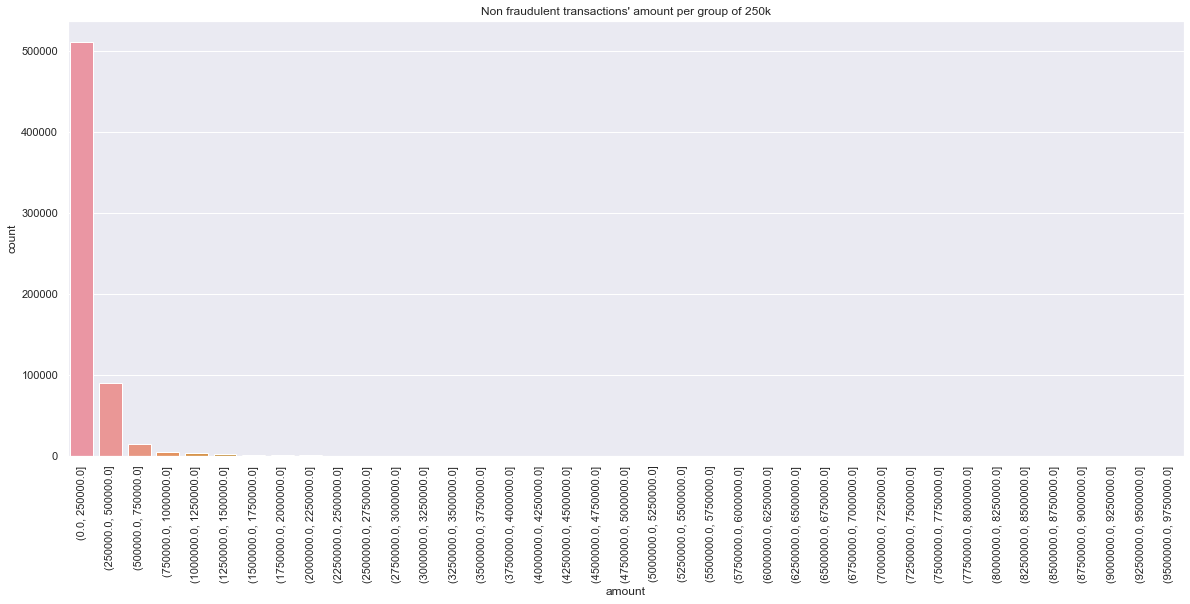

In [83]:
plt.figure(figsize=(20,8))
sns.countplot( x=amount_binned).set_title("Non fraudulent transactions' amount per group of 250k")
# rotate x axis
plt.xticks(rotation=90);

<AxesSubplot:xlabel='isFraud', ylabel='FlowOrig'>

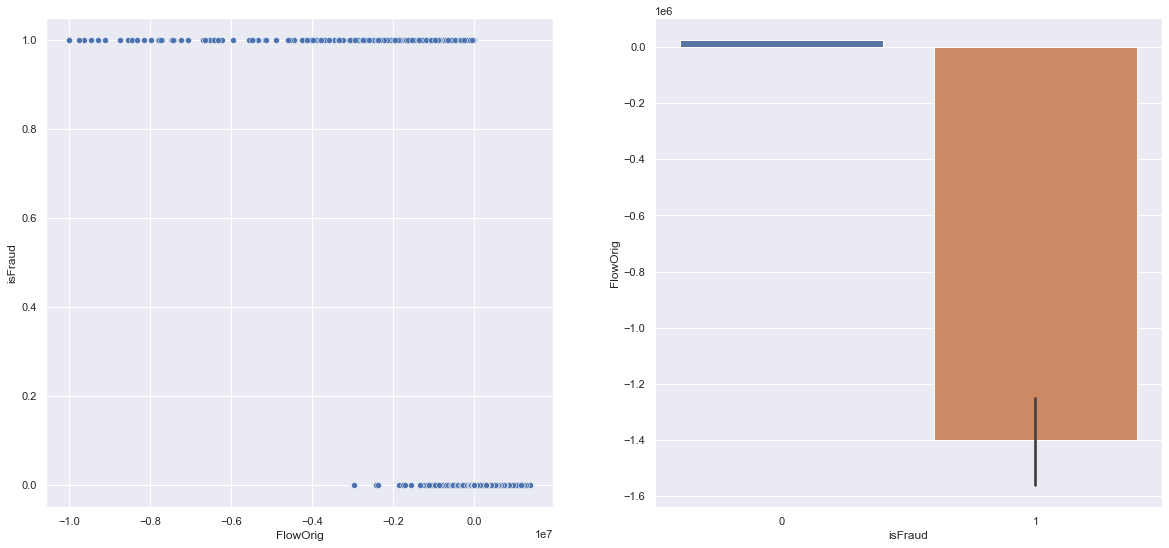

In [84]:
plt.figure(figsize=(20,9))
plt.subplot(1, 2, 1)
sns.scatterplot( x='FlowOrig', y='isFraud', data=df2 ) 
plt.subplot(1, 2, 2)
sns.barplot(x='isFraud', y='FlowOrig', data=df2)

<AxesSubplot:xlabel='isFraud', ylabel='FlowDest'>

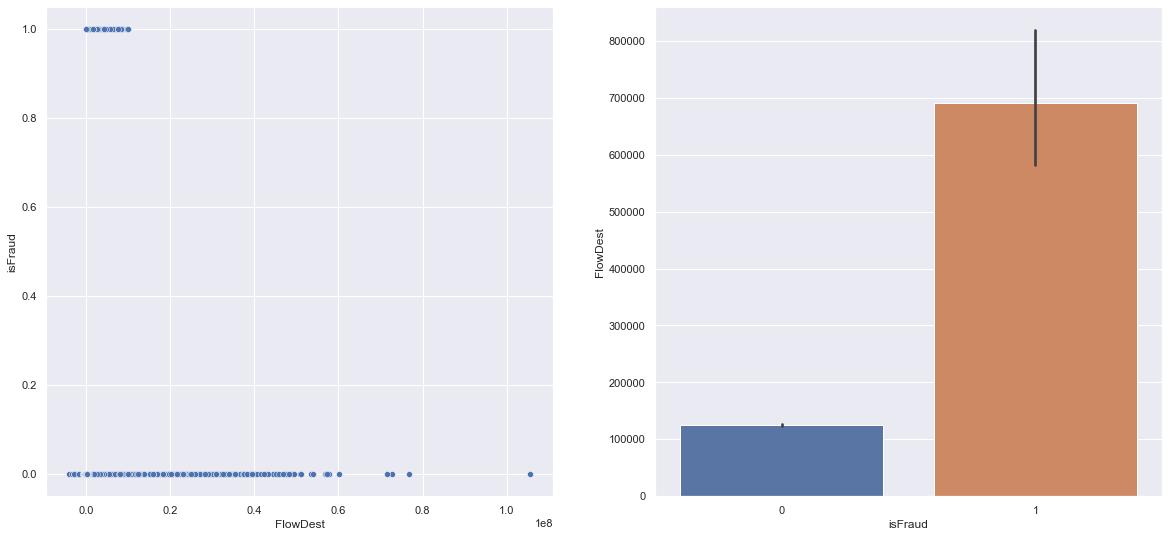

In [85]:
plt.figure(figsize=(20,9))
plt.subplot(1, 2, 1)
sns.scatterplot( x='FlowDest', y='isFraud', data=df2) 
plt.subplot(1, 2, 2)
sns.barplot(x='isFraud', y='FlowDest', data=df2)

### H4
**H4.** fraudadores nunca usam o mesmo nome **Verdade!**

Provado na 1st feature engineering

### H5
**H5.** fraudadores começam a conta com 0 **Falso!**

**Fraudadores não começam com conta no zero**

O contrário é verdadeiro, fraudadores começam com mais dinheiro na conta
33% dos não fraudadores começam com nada em conta e 75% com menos de 250,000

In [86]:
aux_fraud=df2[df2['isFraud']==1]
aux_fraud.describe().oldbalanceOrg

count    8.210000e+02
mean     1.583776e+06
std      3.458584e+06
min      0.000000e+00
25%      1.216268e+05
50%      4.171291e+05
75%      1.506795e+06
max      4.731626e+07
Name: oldbalanceOrg, dtype: float64

In [87]:
aux_notfraud=df2[df2['isFraud']==0]
aux_notfraud.describe().oldbalanceOrg

count    6.354410e+05
mean     8.313345e+05
std      2.885419e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.396400e+04
75%      1.068920e+05
max      3.753800e+07
Name: oldbalanceOrg, dtype: float64

In [88]:
# transferência de fraudes possuem média, mediana e std maiores. No entanto, o máximo é menor
(aux_fraud.describe().oldbalanceOrg)/(aux_notfraud.describe().oldbalanceOrg)

count     0.001292
mean      1.905101
std       1.198642
min            NaN
25%            inf
50%      29.871749
75%      14.096425
max       1.260489
Name: oldbalanceOrg, dtype: float64

In [89]:
# Porcentagem de contas começando com balanço zero:
(df2[df2['oldbalanceOrg']==0].groupby('isFraud').count()['oldbalanceOrg'])/(df2.groupby('isFraud').count()['oldbalanceOrg'])*100

isFraud
0    33.187818
1     0.243605
Name: oldbalanceOrg, dtype: float64

In [90]:
df2[['isFraud','amount','oldbalanceOrg','oldbalanceDest','FluxOrig','FluxDest']].groupby('isFraud').mean()

amount  oldbalanceOrg  oldbalanceDest  FluxOrig  FluxDest
isFraud                                                                 
0        1.790815e+05   8.313345e+05    1.097206e+06 -0.229916  0.245209
1        1.414504e+06   1.583776e+06    5.090219e+05 -0.995128  0.499391

In [91]:
bins1 = list(np.arange(0, 1e7, 2.5e5))
amount_binned = pd.cut(aux_fraud['oldbalanceOrg'], bins=bins1)
(amount_binned.value_counts(normalize=True)*100).head(5)

(0.0, 250000.0]           39.798489
(250000.0, 500000.0]      14.609572
(500000.0, 750000.0]       8.816121
(750000.0, 1000000.0]      6.423174
(1000000.0, 1250000.0]     4.408060
Name: oldbalanceOrg, dtype: float64

In [92]:
bins1 = list(np.arange(0, 1e7, 2.5e5))
amount_binned = pd.cut(aux_notfraud['oldbalanceOrg'], bins=bins1)
(amount_binned.value_counts(normalize=True)*100).head(5)

(0.0, 250000.0]           75.743685
(250000.0, 500000.0]       6.346147
(500000.0, 750000.0]       2.403164
(750000.0, 1000000.0]      1.272206
(1000000.0, 1250000.0]     0.789670
Name: oldbalanceOrg, dtype: float64

### H6
**H6.** Para a origem, fluxo diferente de amount indica fraude **Falso**

O contrário é verdade, fluxo de caixa igual a amount indica que é fraude!!!

In [93]:
df2['type'].unique()

array(['CASH_IN', 'CASH_OUT', 'PAYMENT', 'DEBIT', 'TRANSFER'],
      dtype=object)

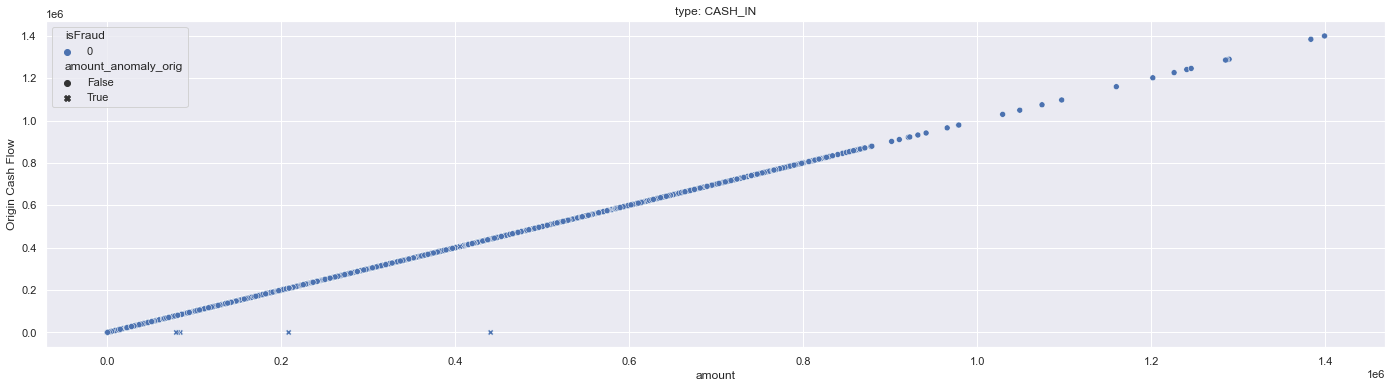

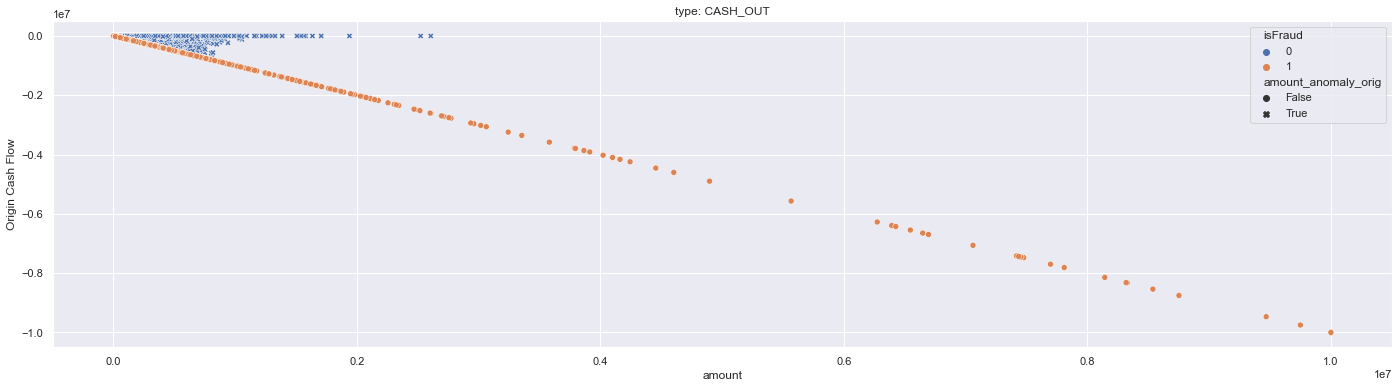

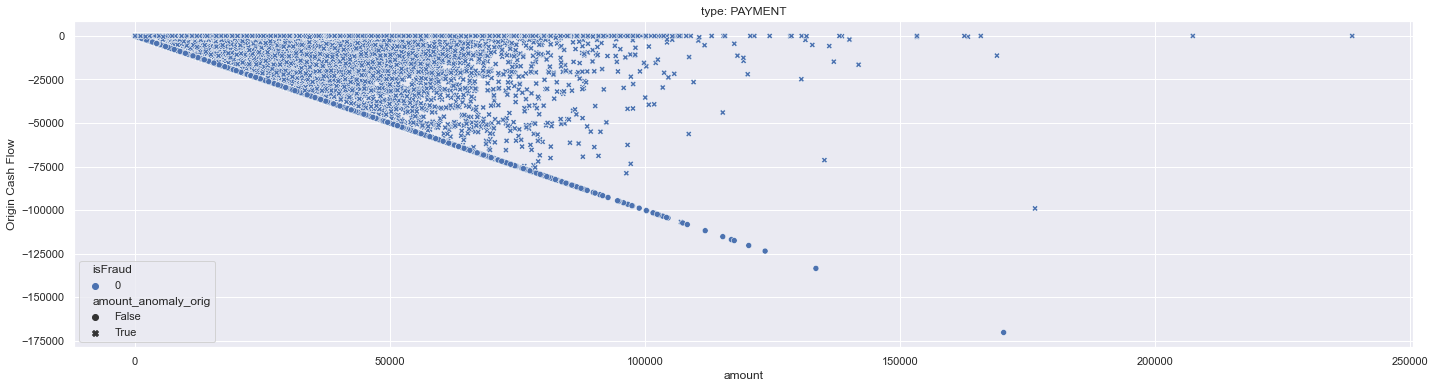

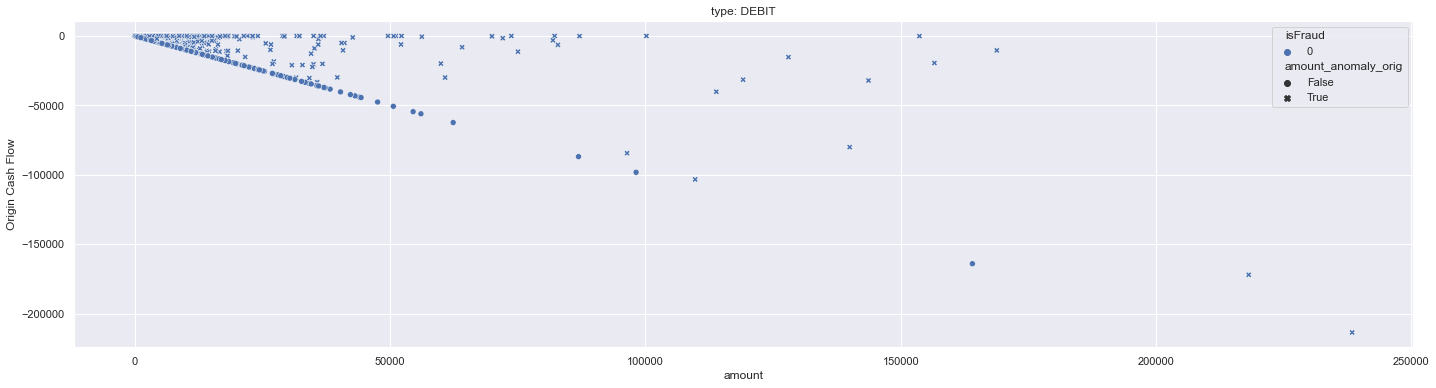

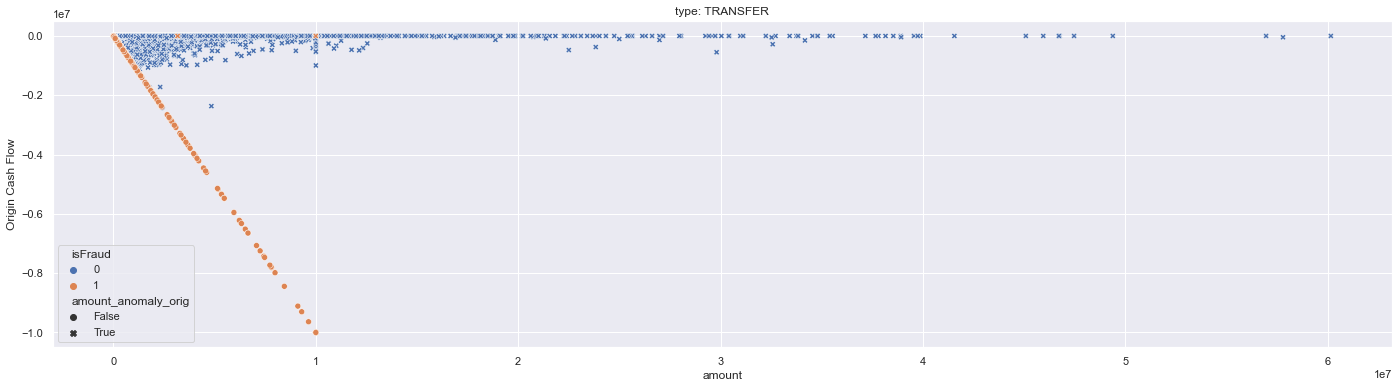

In [94]:
for var in df2['type'].unique():
    plt.figure(figsize=(24,6))
    sns.scatterplot(x='amount',y='FlowOrig',data=df2[df2['type']==var],hue='isFraud',style='amount_anomaly_orig')
    plt.ylabel('Origin Cash Flow')
    plt.title('type: ' + var)
    plt.show()

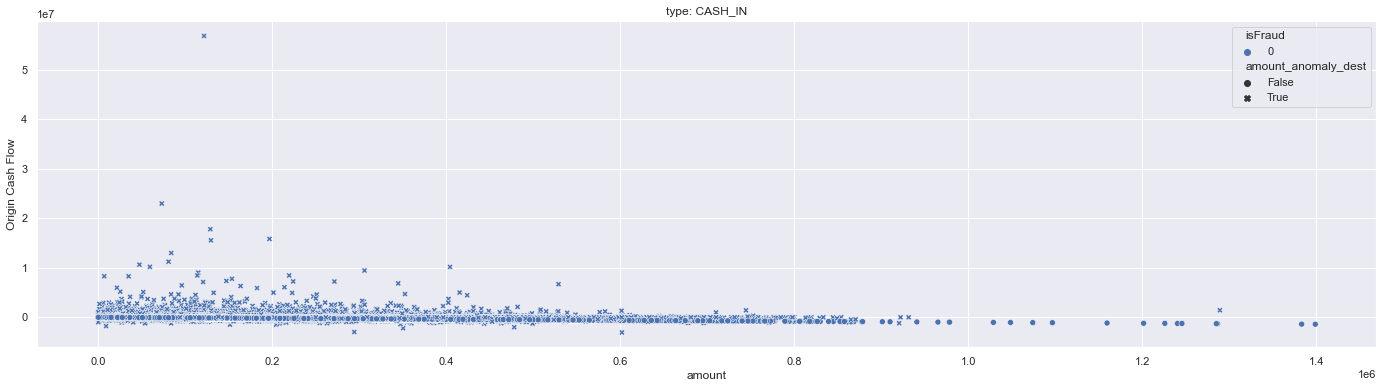

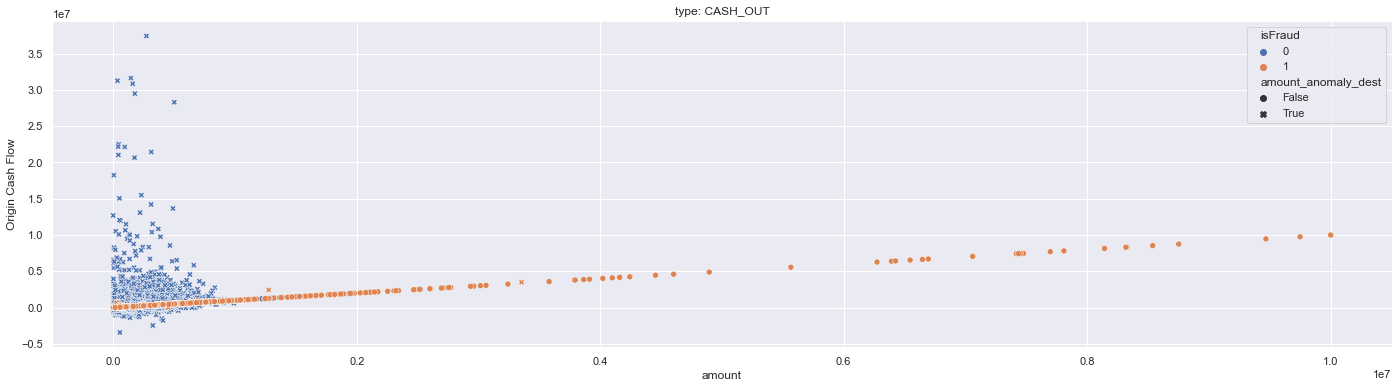

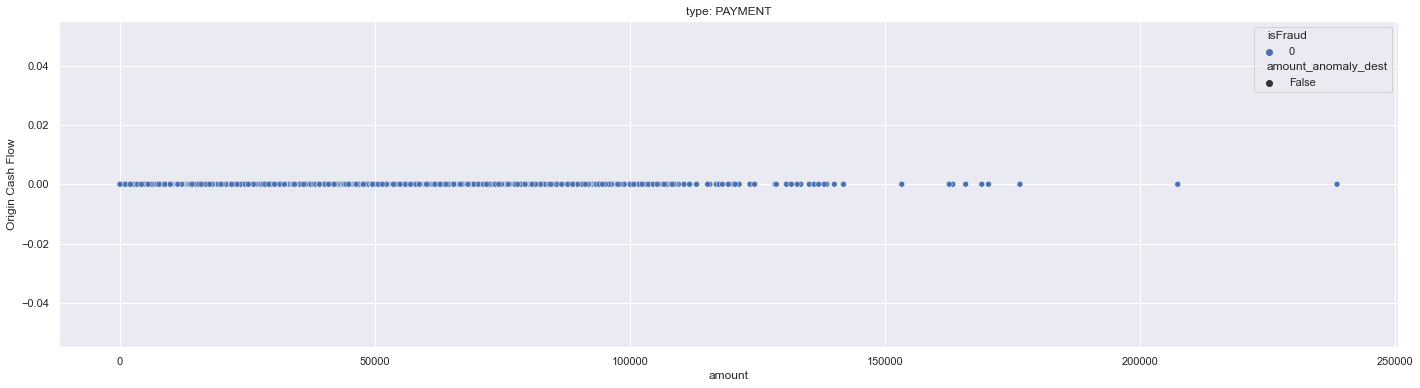

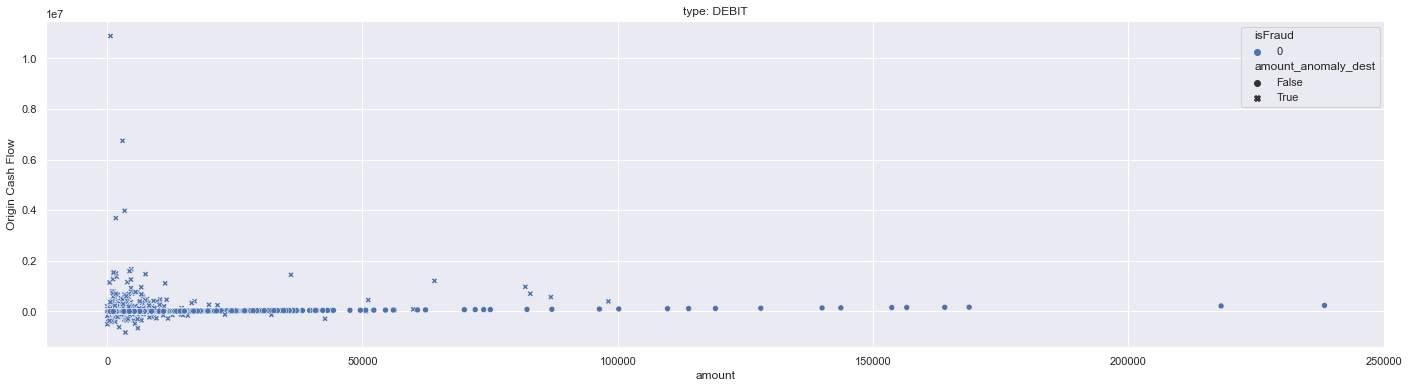

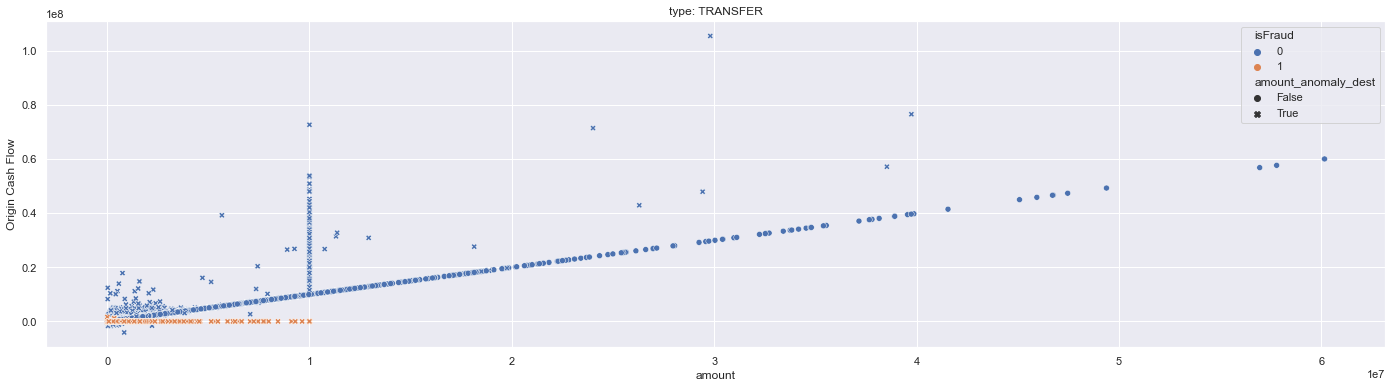

In [131]:
for var in df2['type'].unique():
    plt.figure(figsize=(24,6))
    sns.scatterplot(x='amount',y='FlowDest',data=df2[df2['type']==var],hue='isFraud',style='amount_anomaly_dest')
    plt.ylabel('Origin Cash Flow')
    plt.title('type: ' + var)
    plt.show()

### H7
**H7.** fraudadores gostam mais de fraudar com pessoas físicas **Verdade!**

Provado na análise univariada

### H8
**H8.** Alguma correlacao entre a primeira letra e fraudes **Verdade!**

Merchants nunca são fraudados, e saceitam apenas payment, logo deve-se também deletar a coluna nameDest_char

<AxesSubplot:xlabel='nameDest_char'>

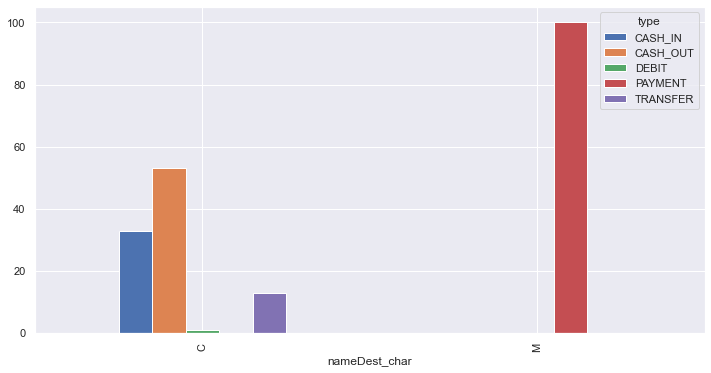

In [96]:
aux01 = pd.crosstab( df2['nameDest_char'], df2['type'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux01.plot.bar(figsize=(12,6))

### H9
**H6.** Para o recipiente, fluxo diferente de amount indica fraude **Parcialmente falso**

Provado em H6.
* Fluxo de caixa igual a amount indica que é fraude em cash_out
* Fluxo de caixa em transfer nulo indica que é fraude

### H10
**H10.** Fluxo negativo indica fraude **Falso!** não tem a ver

Provado em análise univariada categórica

* Na origem todas as fraudes tem como origem compra (outflow)
* No recepiente maior parte das fraudes tem como destino venda (inflow)

### H11
**H11.** flagged fraud quase não tem falso-positivo **Falso!** 

Provado em análise univariada categórica

FlaggedFraud não é uma variável muito útil

## Outros insights de analise bivariada

### pairplot

In [99]:
# num_attributes = df2.select_dtypes( include=['int64', 'float64'] )

In [100]:
# sns.pairplot(num_attributes)

### type vs anomalia no fluxo

**Analise**

proporcao de cash out e transfer aumenta com anomalia no amount

<AxesSubplot:xlabel='amount_anomaly_orig'>

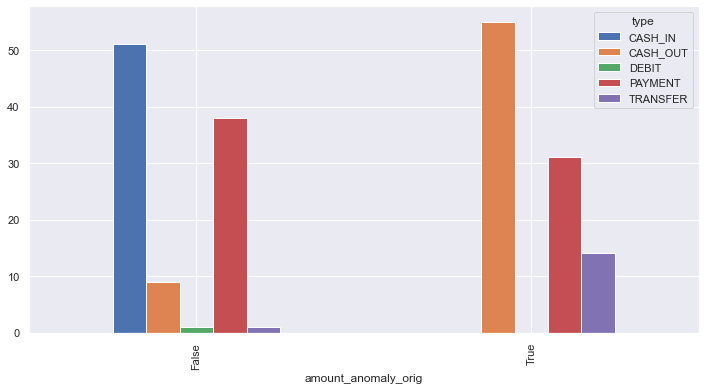

In [101]:
aux01 = pd.crosstab( df2['amount_anomaly_orig'], df2['type'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux01.plot.bar(figsize=(12,6))

<AxesSubplot:xlabel='amount_anomaly_dest'>

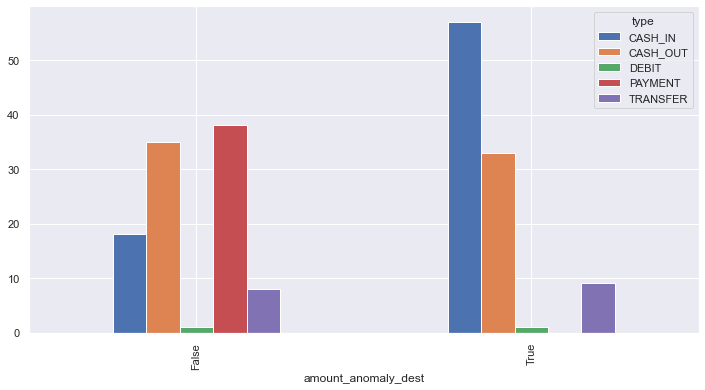

In [102]:
aux01 = pd.crosstab( df2['amount_anomaly_dest'], df2['type'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux01.plot.bar(figsize=(12,6))

### type vs tipo de fluxo

**Analise**

Origen:

nao mostra muita coisa

Destino:

com 0 transferência é sempre fraudulenta

Text(0.5, 1.0, 'fraudulent')

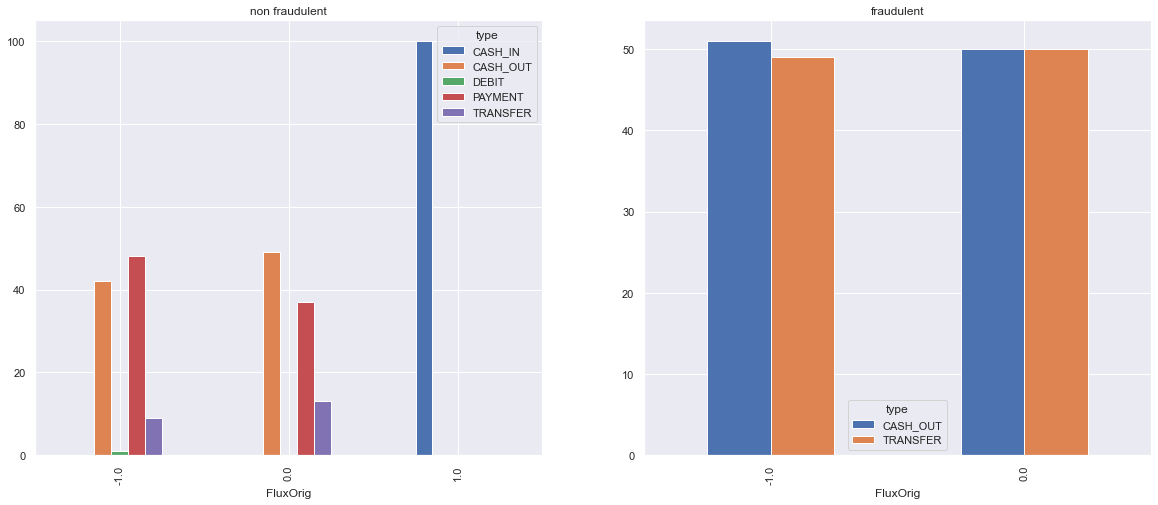

In [103]:
plt.subplots(figsize=(20,8))
ax1=plt.subplot(1, 2, 1)
aux1=df2[df2['isFraud']==0]
aux1 = pd.crosstab( aux1['FluxOrig'], aux1['type'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux1.plot.bar(ax=ax1)
plt.title('non fraudulent')
ax2=plt.subplot(1, 2, 2)
aux2=df2[df2['isFraud']==1]
aux2 = pd.crosstab( aux2['FluxOrig'], aux2['type'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux2.plot.bar(ax=ax2)
plt.title('fraudulent')

Text(0.5, 1.0, 'fraudulent')

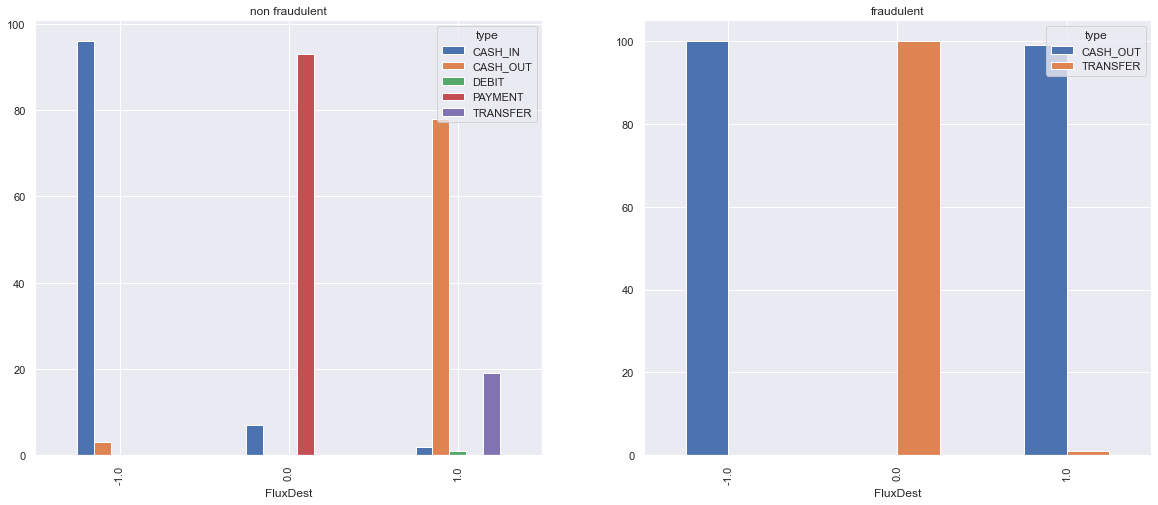

In [104]:
plt.subplots(figsize=(20,8))
ax1=plt.subplot(1, 2, 1)
aux1=df2[df2['isFraud']==0]
aux1 = pd.crosstab( aux1['FluxDest'], aux1['type'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux1.plot.bar(ax=ax1)
plt.title('non fraudulent')
ax2=plt.subplot(1, 2, 2)
aux2=df2[df2['isFraud']==1]
aux2 = pd.crosstab( aux2['FluxDest'], aux2['type'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux2.plot.bar(ax=ax2)
plt.title('fraudulent')

### Transferencia para si mesmo?

não existe

In [105]:
(df1['nameOrig']==df1['nameDest']).sum()

0

## Second feature engineering

In [106]:
df3=df2.copy()

In [107]:
df3.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'isFraud',
       'isFlaggedFraud', 'FlowOrig', 'FlowDest', 'amount_anomaly_orig',
       'amount_anomaly_dest', 'FluxOrig', 'FluxDest', 'disc_orig_amount',
       'disc_dest_amount', 'nameDest_char', 'num_of_transactions_dest',
       'num_of_transactions_orig', 'day', 'hour'],
      dtype='object')

### Criando feature flux

In [108]:
#Essa variavel deveria mostrar se o fluxo esta certo (-1 significa entrando de uma fonte e saindo da outra)
df3['Flux']=df3['FluxOrig']*df3['FluxDest']

<AxesSubplot:xlabel='isFraud'>

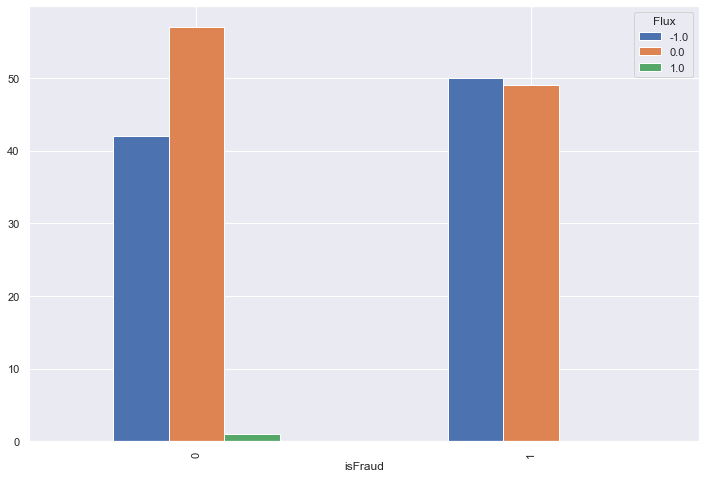

In [109]:
aux1 = pd.crosstab( df3['isFraud'], df3['Flux'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux1.plot.bar(figsize=(12,8))

In [110]:
df3.groupby('Flux').count()

step    type  amount  oldbalanceOrg  oldbalanceDest  isFraud  \
Flux                                                                   
-1.0  265823  265823  265823         265823          265823   265823   
 0.0  363819  363819  363819         363819          363819   363819   
 1.0    6620    6620    6620           6620            6620     6620   

      isFlaggedFraud  FlowOrig  FlowDest  amount_anomaly_orig  \
Flux                                                            
-1.0          265823    265823    265823               265823   
 0.0          363819    363819    363819               363819   
 1.0            6620      6620      6620                 6620   

      amount_anomaly_dest  FluxOrig  FluxDest  disc_orig_amount  \
Flux                                                              
-1.0               265823    265823    265823            265823   
 0.0               363819    363819    363819            363819   
 1.0                 6620      6620      6620              6620   

      disc_dest_amount  nameDest_char  num_of_transactions_dest  \
Flux                                                              
-1.0            265823         265823                    265823   
 0.0            363819         363819                    363819   
 1.0              6620           6620                      6620   

      num_of_transactions_orig     day    hour  
Flux                                            
-1.0                    265823  265823  265823  
 0.0                    363819  363819  363819  
 1.0                      6620    6620    6620

### rever correlacao e remover variaveis redudantes

**continous**

remover: amount, step, new balances, flowdest

**categorical**

remover: nameDest_char, flux, fluxdest, isflaggedfraud

In [111]:
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [112]:
(df1['amount']<0).sum()

0

In [113]:
df3=pd.concat([df3,df1[['newbalanceOrig','newbalanceDest']]],axis=1)

In [114]:
aux=df3

<AxesSubplot:>

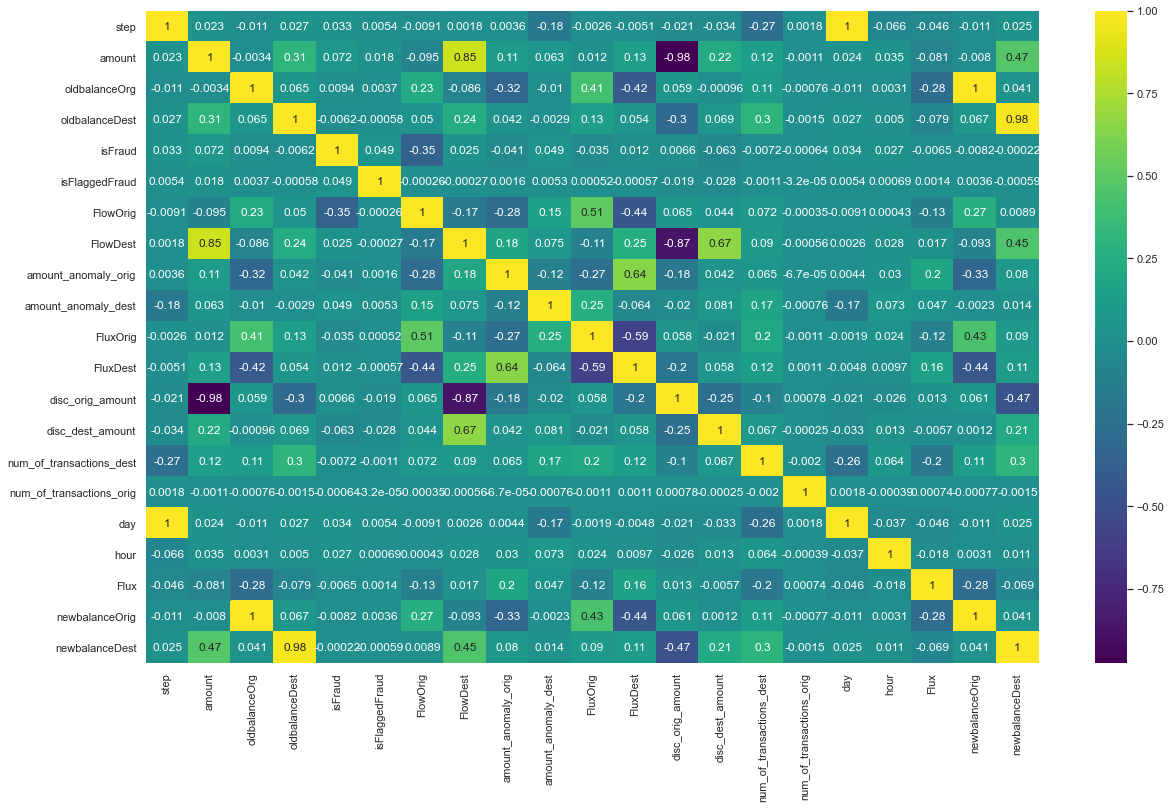

In [115]:
plt.figure(figsize=(20,12))
sns.heatmap(aux.corr(method='pearson'),cmap='viridis',annot=True)

In [116]:
discrete,continuous,categorical=variable_types(aux)

There are 11 discrete variables
There are 10 continuous variables
There are 2 categorical variables


In [117]:
cat=aux[categorical+discrete].applymap(str)

In [118]:
cat_attributes_list = cat.columns

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v( aux[ ref ], aux[ feat ] )
        
        # append a list
        corr_list.append( corr )
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

<AxesSubplot:>

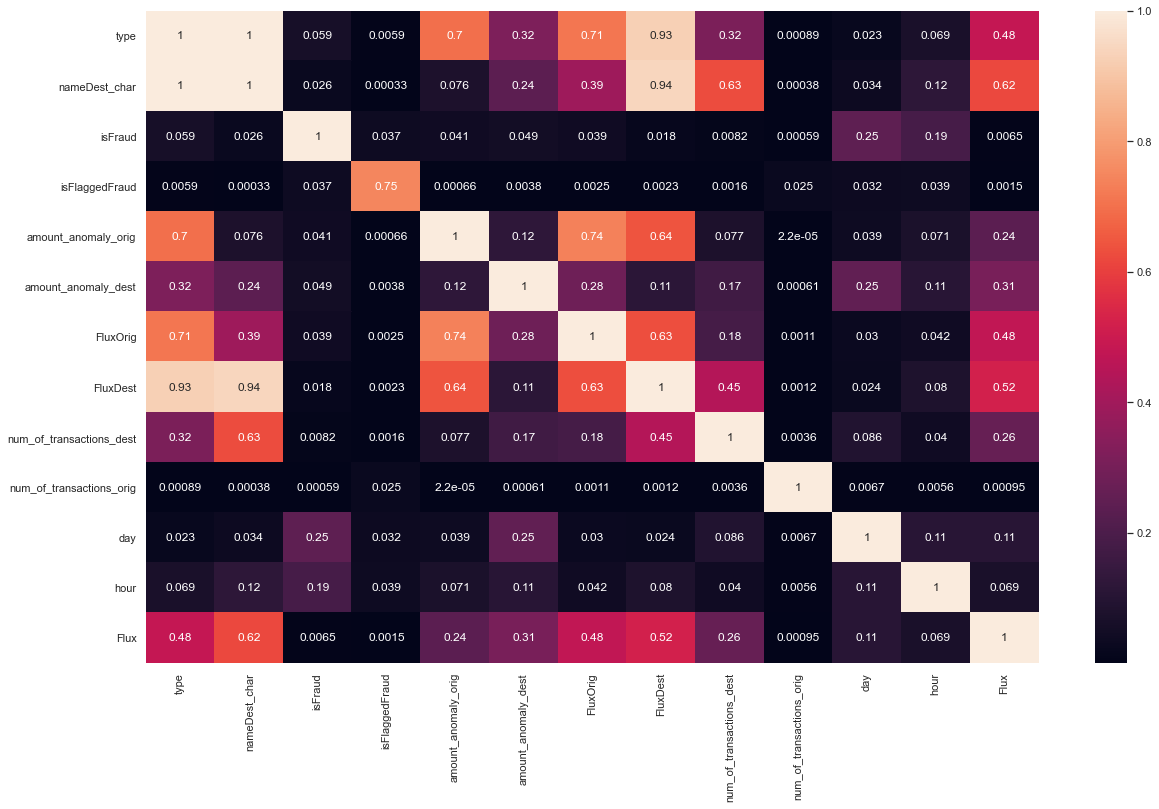

In [119]:
plt.figure(figsize=(20,12))
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True )

# FEATURE SELECTION

In [145]:
df3.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'isFraud',
       'isFlaggedFraud', 'FlowOrig', 'FlowDest', 'amount_anomaly_orig',
       'amount_anomaly_dest', 'FluxOrig', 'FluxDest', 'disc_orig_amount',
       'disc_dest_amount', 'nameDest_char', 'num_of_transactions_dest',
       'num_of_transactions_orig', 'day', 'hour', 'Flux', 'newbalanceOrig',
       'newbalanceDest'],
      dtype='object')

In [146]:
#manual selection
df4=df3.drop(['step','amount','isFlaggedFraud','FluxDest','Flux','newbalanceOrig',\
         'newbalanceDest','FlowDest','nameDest_char'],axis=1)

In [ ]:
# #manual selection
# df4=df3.drop(['step','isFlaggedFraud','FlowOrig','FlowDest',\
#          'nameDest_char','Flux'],axis=1)